# <font color='orangered'>ATTENTION
### - This notebook is best viewed with a dark background
### - powered by Team WAR&trade;. 

# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone.


In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [71]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse       import urlparse
from itertools          import chain, combinations
from typing             import Any, Dict, List, Union, Tuple, Optional
from IPython.display import HTML, display

# Data Science Libraries
import numpy    as np
import pandas   as pd

# Visualization
import matplotlib.pyplot    as plt
import matplotlib.patches   as patches
import matplotlib.ticker    as mticker  # Optional: Format y-axis labels as dollars
import seaborn              as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.base               import BaseEstimator
from sklearn.preprocessing      import StandardScaler, OrdinalEncoder
from sklearn.impute             import SimpleImputer
from sklearn.metrics            import mean_squared_error, root_mean_squared_error
from sklearn.feature_selection  import SequentialFeatureSelector, f_regression, SelectKBest, RFE
from sklearn.linear_model       import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.ensemble           import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree               import DecisionTreeRegressor
from sklearn.inspection         import permutation_importance
from sklearn.calibration        import cross_val_predict
from sklearn.exceptions         import ConvergenceWarning

# Progress Tracking
from tqdm                       import tqdm

# To avoid constant warnings about jobs:
#        UserWarning: A worker stopped while some jobs were given to the executor.
#        This can be caused by a too short worker timeout or by a memory leak.

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Suppress specific LinAlgWarning messages
warnings.filterwarnings(action = 'ignore', message  = '.*Ill-conditioned matrix.*')
warnings.filterwarnings(action = 'ignore', category = RuntimeWarning, message = '.*Ill-conditioned matrix.*')
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings(action = 'ignore')

## Global variables

In [72]:
# =============================
# Global Variables
# =============================
random_state = 42

plot_patch_color = 'mistyrose'

## dictionary of column names of dataframe to store results for each ensemble method. ##
ensemble_df_columns = {
    'BaggingRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'max_samples', 'max_features', 'bootstrap', 'execution_time', 'timestamp'],
    'RandomForestRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'max_depth', 'max_features', 'bootstrap', 'execution_time', 'timestamp'],
    'GradientBoostingRegressor': ['Model', 'Test_Param','cv_repeats', '(R)MSE_found', 'test_(R)MSE', 'n_estimators', 'learning_rate', 'max_depth', 'max_features', 'bootstrap', 'execution_time', 'timestamp']
}


## Utility Functions


### Formatting & Cleaning

In [73]:
def set_background(color):
    script = ("var cell = this.closest('.code_cell');"
              "var editor = cell.querySelector('.input_area');"
              "editor.style.background='{}';" 
              "this.parentNode.removeChild(this)"
             ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [74]:
# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

In [75]:
# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [76]:
def process_results(
        search: Any, 
        exp_factor: float = 1
) -> pd.DataFrame:
    
    """
    Processes the cross-validation results from a search algorithm (GridSearchCV or RandomizedSearchCV) and formats them into a readable DataFrame.

        Parameters:
            - search: The search object (GridSearchCV or RandomizedSearchCV) after fitting.
            - exp_factor: The exponent factor to apply to the scores. Use 0.5 for RMSE (Root Mean Squared Error) or 1 for MSE (Mean Squared Error).

        Returns:
            - A DataFrame containing the relevant columns from the search results, with scores converted and columns renamed for readability.
    """
    results_df = pd.DataFrame(search.cv_results_)
    print(f'results_df.columns:\n {results_df.columns}')
    # print(f'results_df:\n {results_df}')    


    # Selecting relevant columns for readability
    columns_to_select = [
        'param_n_estimators', 'param_max_samples', 'param_max_features', 'param_learning_rate', 'param_max_depth',  
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]

    # Filter out columns that are not present in the results
    columns_to_select   = [col for col in columns_to_select if col in results_df.columns]
    results_df          = results_df[columns_to_select]


    # Convert negative MSE to positive; for square root, set exp_factor = 0.5 
    results_df['std_test_score']    = results_df['std_test_score'] ** exp_factor
    results_df['std_train_score']   = results_df['std_train_score'] ** exp_factor
    results_df['mean_test_score']   = (-results_df['mean_test_score']) ** exp_factor
    results_df['mean_train_score']  = (-results_df['mean_train_score']) ** exp_factor
    
    # Sort by rank (best scores first)
    results_df = results_df.sort_values(by='rank_test_score').round(3)

    # Rename columns for printing only
    renamed_results_df = results_df.rename(columns={
        'param_learning_rate':  'learning_rate',
        'param_n_estimators':   'n_estimators',
        'param_max_samples':    'max_samples',
        'param_max_depth':      'max_depth',
        'param_max_features':   'max_features',
        'mean_test_score':      'mean_cv_score',
        'std_test_score':       'std_cv_score',
        'mean_train_score':     'mean_train_score',
        'std_train_score':      'std_train_score'
    }).drop(columns=['rank_test_score'])

    return renamed_results_df

In [77]:
def df_format_dropDuplicateRows(df, column = None):
    '''
    For a given dataframe, replace all NaN values with None, drop duplicate rows, 
    format the specified column, return the cleaned dataframe.
    '''
    df = df.replace({np.nan: None}).drop_duplicates()
    
    return df

In [78]:
def df_col_check(df_columns: list, best_params_dict: dict):
    """
        If the destination dataframe of ensemble method results contains a column name that isn't a key in the best parameters dictionary, 
        populate the column with 'None' 
    """

    for col in df_columns:
        if col not in best_params_dict:
            best_params_dict[col] = None

In [79]:
def build_best_params_df(
    search: Any,  # Typically a GridSearchCV or RandomizedSearchCV object
    best_CV_MSE: float,
    execution_time: float,
    timestamp: str,
    model_name: str,
    # test_mse: float,
    model_df_cols: List[str],
    test_param: str,
    n_repeats: int
) -> pd.DataFrame:
    
    """
        Processes the best parameters found by a search algorithm (GridSearchCV or RandomizedSearchCV) and formats them into a DataFrame.
            Parameters:
                - search: The search object (GridSearchCV or RandomizedSearchCV) after fitting.
                - best_CV_MSE: The best cross-validation mean squared error found by the search.
                - execution_time: The time taken to execute the search.
                - model_name: The name of the model being evaluated.
                - test_mse: The mean squared error on the test set.
                - model_df_cols: The columns expected in the resulting DataFrame.
                - test_param: A string indicating whether GridSearchCV or RandomizedSearchCV was used.
                - n_repeats: The number of cross-validation repeats.

            Returns:
                - A DataFrame containing the best parameters and additional metadata.
    """
    
    best_params                     = search.best_params_
    best_params['Model']            = model_name
    best_params['(R)MSE_found']     = round(best_CV_MSE,3)
    # best_params['test_(R)MSE']      = round(test_mse, 3)
    best_params['Test_Param']       = test_param
    best_params['cv_repeats']       = n_repeats
    best_params['execution_time']   = execution_time
    best_params['timestamp']        = timestamp

    df_col_check(model_df_cols, best_params)
    best_params_df = pd.DataFrame([best_params], columns = model_df_cols)
    best_params_df = df_format_dropDuplicateRows(best_params_df)

    return best_params_df


In [80]:

def plot_bar_chart(ax, df, color_min = 'red', color_other = 'midnightblue'):
    """
    Plots a horizontal bar chart for the given DataFrame.

        Parameters:
            - ax: The matplotlib axis to plot on.
            - df: The DataFrame containing the data to plot.
            - color_min: Color for the minimum value bar.
            - color_other: Color for all other bars.
    """
    
    min_value   = df['mean_cv_mse'].min()
    colors      = [color_min if value == min_value else color_other for value in df['mean_cv_mse']]
    
    ax.barh(df['model'], df['mean_cv_mse'], color=colors)
    ax.set_xlabel(f'Mean CV {df["metric_label"].iloc[0]} ({df["cv_folds"].iloc[0]} folds, {df["n_repeats"].iloc[0]} repeats)')
    ax.tick_params(labelsize = 7)
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    ax.set_title(f'Mean CV {df["metric_label"].iloc[0]}: {df["Feature_Set"].iloc[0]}')
    ax.grid(axis='x')

### Sequential Selection

In [81]:
def get_best_sequential_selection(dict1, dict2, item:str, smaller_is_better:bool) -> dict:
    # Extract scores from the dictionaries
    score1 = dict1.get(item, float('inf') if smaller_is_better else float('-inf'))
    score2 = dict2.get(item, float('inf') if smaller_is_better else float('-inf'))
    
    # Determine the best score based on the flag
    if smaller_is_better:
        best_dict = dict1 if score1 < score2 else dict2
    else:
        best_dict = dict1 if score1 > score2 else dict2
    # print(f"Best dictionary based on {item}: {best_dict}")
    print(f"Score from dict1: {score1}, Score from dict2: {score2}")
    print(f'Best feature set: {best_dict['direction']}, {best_dict["best_feature_set"]}')
    return best_dict

#### Forward Selection

In [82]:
def sequential_feature_selection(
                                X: pd.DataFrame,
                                y: np.ndarray,
                                model: BaseEstimator,
                                feature_set: Optional[str],  # Feature set name,
                                direction: str               ='forward',  # 'forward' or 'backward'
                                scoring: str                 = 'neg_mean_squared_error',
                                show_RMSE: bool              = False,
                                cv: int                      = 5,
                                tol: Optional[float]         = None,               # None = no delta cutoff
                                max_features: Optional[int]  = None,      # None = use all features
                                n_jobs: int                  = -1,
                                verbose: bool                = False,
                                patience: Optional[int]      = None # Stop if no improvement for 'patience' steps
                                ) -> dict:

    """
    Performs sequential feature selection (forward or backward).

    Args:
        X (pd.DataFrame or np.ndarray):     Feature matrix.
        y (pd.Series or np.ndarray):        Target vector.
        model:                              Estimator instance to use for feature selection.
        direction (str, optional):          'forward' or 'backward' selection. Defaults to 'forward'.
        scoring (str or callable, optional):Scoring metric to use. Default = 'neg_mean_squared_error'.
        cv (int):                           Number of Cross-validation folds. Defaults = 5.
        tol (float, optional):              Tolerance for stopping the selection. If the absolute improvement in score is less than tol, the selection stops. Defaults to None.
        max_features (int, optional):       Max number of features to select. Default = None (all features).
        n_jobs (int, optional):             Number of jobs to run in parallel. Defaults to -1.
        verbose (bool, optional):           For printing progress updates. Defaults to False.
        patience (int, optional):           Number of steps with no improvement before stopping. Defaults to None.

    Returns:
        dictionary:
            - selected_features (list): List of selected feature names (in order of selection).
            - best_scores (list): List of cross-validation scores at each step of selection.
            - best_feature_set (list): Subset of features that achieved the best CV score.
            - best_score (float): Best CV score achieved.
    """


    start            = time.time()

    if max_features is None or max_features >= X.shape[1]:
        max_features = X.shape[1]

    # for calculating and displaying Root MSE instead of MSE
    if show_RMSE:
      exp_factor    =  0.5
      metric_label  = 'RMSE'
    else:
      exp_factor    =  1
      metric_label  = 'MSE'


    selected_features_mask = np.zeros(X.shape[1], dtype=bool)
    best_scores         = []
    current_features    = []
    best_feature_set    = []
    best_score          = float('inf') if scoring.startswith('neg') else float('-inf')
    greater_is_better   = not scoring.startswith('neg')
    num_features        = X.shape[1]
    remaining_features  = list(X.columns) if isinstance(X, pd.DataFrame) else list(np.arange(num_features))
    no_improvement_count = 0

    print(f"All features: {remaining_features}\n")

    for i in range(min(max_features, num_features)):
        best_new_feature = None
        best_new_score   = float('inf') if scoring.startswith('neg') else float('-inf')

        for feature in remaining_features:
            temp_features = current_features + [feature]
            cv_score = round((-cross_val_score(model,
                                                X[temp_features] if isinstance(X, pd.DataFrame) else X[:, temp_features],
                                                y,
                                                scoring=scoring,
                                                cv=cv,
                                                n_jobs=n_jobs
                                              ).mean()) ** exp_factor, 4)

            if (greater_is_better and cv_score > best_new_score) or (not greater_is_better and cv_score < best_new_score):
                best_new_score   = cv_score
                best_new_feature = feature

        if best_new_feature is not None:
            current_features.append(best_new_feature)
            best_scores.append(best_new_score)
            remaining_features.remove(best_new_feature)

            if verbose:
                print(f"Added: {best_new_feature}, CV Score ({metric_label})({scoring}): {best_new_score:,.4f}")

            if (greater_is_better and best_new_score > best_score) or (not greater_is_better and best_new_score < best_score):
                best_score        = best_new_score
                best_feature_set  = current_features.copy()
                no_improvement_count = 0 # Reset counter

            elif patience is not None:
                no_improvement_count += 1
                if no_improvement_count >= patience:
                    if verbose:
                        print(f"Stopping early - no improvement for {patience} steps.")
                    break

            elif tol is not None and i > 0:
                improvement = abs(best_new_score - best_scores[-2])
                if improvement < tol:
                    if verbose:
                        print(f"Stopping early - improvement less than tolerance ({tol}).")
                    break
        else:
            if verbose:
                print("No more features to add that improve the score.")
            break

    end               = time.time()
    execution_time    = format_hms(end - start)
    timestamp         = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))

    print(f'\nExecution time: {execution_time}')
    print(f'Timestamp: {timestamp}')
    print("--------------------------------------------------------------------")

    ############################   CHART     #####################################
    plt.figure(figsize=(8, 5))
    plt.gcf().patch.set_facecolor(f'{plot_patch_color}')

    plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
    if best_feature_set:
        index_best = len(best_feature_set)
        plt.plot(index_best, best_score, marker='x', color='red')

    plt.title(f'Forward Feature Selection and CV Scores ({metric_label}): {model.__class__.__name__}')
    plt.xlabel('Number of Features')
    plt.ylabel(f'CV Score ({metric_label})')

    plt.xticks(range(1, len(current_features) + 1), current_features, rotation=45, ha='right', fontsize=6)

    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}')) if show_RMSE else None
    plt.gca().tick_params(axis='y', labelsize=7)
    plt.grid()
    plt.tight_layout()
    plt.show()

    #--------------------------------------------------------------------------------------#
    return {
        'model':              model,
        'feature_set':        feature_set,
        'direction':          direction,
        'selected_features':  current_features, # Features in the order they were selected
        'best_scores':        best_scores,      # CV scores at each step
        'best_feature_set':   best_feature_set, # The subset with the best score
        'best_score':         best_score,
        'execution_time':     execution_time,
        'timestamp':          timestamp,
    }

#### Backwards Selection

In [83]:
# Backward Feature Selection

def backward_feature_selection(
                                X, 
                                y, 
                                model,
                                feature_set: Optional[str],  # Feature set name,
                                scoring      = 'neg_mean_squared_error', 
                                cv           = 5, 
                                tol          = None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                                max_features = None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                                n_jobs       = -1,
                                verbose      = False, 
                                show_RMSE    = False
                              ):
    """
        Performs backward feature selection using cross-validation.

        This function iteratively removes features from the input dataset, evaluating the model's performance
        using cross-validation at each step. It aims to identify the subset of features that yields the best
        cross-validation score.

        Args:
            X (pandas.DataFrame or numpy.ndarray): The feature matrix.
            y (pandas.Series or numpy.ndarray): The target vector.
            model (estimator object): The machine learning model to be used for feature selection.
            feature_set (str, optional): An optional name for the feature set being processed. Defaults to None.
            scoring (str, optional): The scoring metric used for cross-validation. Defaults to 'neg_mean_squared_error'.
            cv (int, optional): The number of cross-validation folds. Defaults to 5.
            tol (float, optional): Tolerance for stopping the selection process. If the improvement in score is less
                than this value, the process stops. Defaults to None, meaning no tolerance cutoff.
            max_features (int, optional): The maximum number of features to retain. If None, features are removed until
                only one remains. Defaults to None.
            n_jobs (int, optional): The number of CPU cores to use for parallel execution. Defaults to -1 (use all cores).
            verbose (bool, optional): If True, prints progress messages. Defaults to False.
            show_RMSE (bool, optional): If True, displays RMSE instead of MSE in the plots and output. Defaults to False.

        Returns:
            dict: A dictionary containing the following information:
                - 'Feature_Set': The name of the feature set (if provided).
                - 'model': The model used for feature selection.
                - 'metric_label': The label of the metric used (RMSE or MSE).
                - 'selected_features': A list showing the order in which features were removed.
                - 'best_scores': A list of cross-validation scores after each feature removal.
                - 'best_feature_set': The subset of features that achieved the best cross-validation score.
                - 'best_score': The best (lowest) cross-validation score.
                - 'execution_time': The execution time of the function.
                - 'timestamp': The timestamp of completion.
                - 'features_remaining': The features remaining after selection.
    """
    exp_factor   = 0.5 if show_RMSE else 1
    metric_label = 'RMSE' if show_RMSE else 'MSE'
        # Helper function to compute cross-validation score for a given feature set and model  
    
    start       = time.time()

    def cv_score(features):
        return round((-cross_val_score(model, 
                                X[features], 
                                y, 
                                scoring = scoring, 
                                cv      = cv, 
                                n_jobs  = n_jobs          
                                ).
                                mean()) ** exp_factor,4)

    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)

    # Compute initial CV score with the full feature set
    initial_score     = cv_score(features_remaining)

    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV Score ({metric_label}): {np.around(initial_score, 4)}\n')

    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features

    prev_score  = initial_score
    round_num   = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score        = float('inf')
        feature_to_remove   = None
        best_new_features   = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            # print(f'Removing {feature}...')
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            
            if not np.isclose(new_score, lowest_score, atol = 1e-8) and new_score <  lowest_score:
            # if new_score < lowest_score:
                lowest_score        = new_score
                feature_to_remove   = feature
                best_new_features   = new_feature_set
                
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if not np.isclose(lowest_score, best_score, atol = 1e-8) and lowest_score <  best_score:
        # if lowest_score < best_score:
            best_score          = lowest_score
            best_feature_set    = best_new_features.copy()
        
        # Update trackers for this round
        prev_score          = lowest_score
        features_remaining  = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV Score {metric_label} = {np.around(lowest_score, 4)}\n')
        round_num += 1

    plt.figure(figsize = (8, 5))
    plt.gcf().patch.set_facecolor(f'{plot_patch_color}')

    plt.title(f'Backward Feature Selection and CV Scores ({metric_label}): {model.__class__.__name__}')
    plt.plot(range(1, len(best_scores) + 1), best_scores, marker = '.', color = 'midnightblue')
    index = np.argmin(best_scores) 
    plt.plot([index + 1], best_scores[index], marker = 'x', color='red')  
    plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation = 45, ha = 'right', fontsize = 6)
    plt.xlabel('Features Removed')
    plt.ylabel(f'CV Score ({metric_label})')
    plt.gca().tick_params(axis='y', labelsize = 7)
    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

    plt.grid()
    plt.tight_layout()
    plt.show()

    # Print minimum cv score

    print("Best feature set:", best_feature_set)
    print(f"CV score {metric_label}): {best_score:,.4f}")


    end             = time.time()
    execution_time  = format_hms(end - start)
    timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'\nExecution time: {execution_time}, finished at {timestamp}')
    print("--------------------------------------------------------------------")

    return {
        'Feature_Set':          feature_set,            # Feature set name
        'model':                model,                   # The model used for feature selection
        'metric_label':         metric_label,
        'direction':            'backward',             # Direction of selection
        'selected_features':    selected_features,      # Order in which features were removed
        'best_scores':          best_scores,            # CV scores after each removal step
        'best_feature_set':     best_feature_set,       # Feature set that achieved the best CV score
        'best_score':           best_score,              # Best (lowest) CV score,
        'execution_time':       execution_time,         # Execution time of the function
        'timestamp':            timestamp,              # Timestamp of completion
        'features_remaining':   features_remaining,     # Features remaining after selection
    }


### run_model

In [84]:
def run_model(
    model: Union[BaseEstimator, type],  # The model or model class,
 
    X_train: Union[pd.DataFrame, np.ndarray],  # Training feature set
    y_train: np.ndarray,  # Training target set
    X_test: Union[pd.DataFrame, np.ndarray],  # Testing feature set
    y_test: np.ndarray,  # Testing target set
    feature_set: str        = None,  # Feature set name,
    cv_folds: int           = 5,  # Number of cross-validation folds
    n_repeats: int          = 5,  # Number of repeats for cross-validation
    n_jobs: int             = -1,  # Number of jobs to run in parallel
    show_RMSE: bool         = False,  # Whether to show RMSE instead of MSE
    target_log_scale: bool  = False,  # Is target variable in log scale? 
    **model_params: Any  # Additional parameters for the model
):
    """
    Runs a machine learning model with cross-validation and computes performance metrics.

        Parameters:
            - model: The machine learning model or model class to be used.
            - X_train: Training feature set.
            - y_train: Training target set.
            - X_test: Testing feature set.
            - y_test: Testing target set.
            - cv_folds: Number of cross-validation folds (default is 5).
            - n_repeats: Number of repeats for cross-validation (default is 5).
            - n_jobs: Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
            - show_RMSE: Whether to show RMSE instead of MSE (default is False).
            - target_log_scale: Whether the target variable is in log scale (default = False). If True, exponentiate the scores. 
            - **model_params: Additional parameters to pass to the model if a class is provided.

        Returns:
            - A dictionary containing:
                - model: The fitted model.
                - metric_label: 'MSE' or 'RMSE'.
                - mean_cv_mse: Mean cross-validated MSE or RMSE.
                - std_cv_mse: Standard deviation of cross-validated MSE or RMSE.
                - cv_folds: Number of cross-validation folds.
                - n_repeats: Number of repeats for cross-validation.
                - execution_time: Time taken to run the model.
                - timestamp: Timestamp of when the function was run.
    """
    
    print(f"Inside run_model, cv_folds = {cv_folds}")

    if isinstance(model, type):
        model       = model(**model_params)

    repeated_kf     = RepeatedKFold(n_splits = cv_folds, n_repeats = n_repeats, random_state = random_state)
    exp_factor      = 0.5 if show_RMSE else 1
    metric_label    = 'RMSE' if show_RMSE else 'MSE'
    model_name      = model.__class__.__name__ if hasattr(model, '__class__') else model
    std_cv_mse      = None
    print(f'Running {model_name} with {metric_label}, feature set: {feature_set}')

    start           = time.time()


######## if the target variable is in log scale .... ####################################
    if target_log_scale:

        # List to store RMSE values for each fold
        # rmse_values = []

        # # Perform manual cross-validation
        # for train_index, test_index in repeated_kf.split(X_train):
        #     X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        #     y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            
        #     # Train the model
        #     model.fit(X_train_fold, y_train_fold)
        #     # Predict on the test fold
        #     log_preds = model.predict(X_test_fold)
        #     y_preds = np.expm1(log_preds)
            
        #     # Calculate RMSE for the fold
        #     rmse = (root_mean_squared_error(y_test_fold, y_preds))
        #     rmse_values.append(rmse)

        # mean_cv_mse = round(np.mean(rmse_values),3)
        # std_cv_mse  = round(np.std(rmse_values),3)
     

        log_y_train     = np.log1p(y_train)
        log_y_test      = np.log1p(y_test)
        log_preds   = cross_val_predict(model, 
                                      X_train, 
                                      y_train, 
                                      cv        = cv_folds, 
                                      n_jobs    = n_jobs
                                      )
        y_preds     = np.expm1(log_preds)

        rmse        = root_mean_squared_error(y_train, y_preds).round(3)   # equivalent to np.sqrt(np.mean((y_train - y_preds) ** 2))
        print(f"RMSE: {rmse:,.3f}")

#### if the target variable is NOT in log scale .... #####################################
    else:
         
        # Perform cross-validation with tqdm progress bar
        neg_mse_scores  = []
        for score in tqdm(cross_val_score(
                            model,
                            X_train,
                            y_train,
                            scoring   = 'neg_mean_squared_error',
                            cv        = repeated_kf,
                            n_jobs    = n_jobs
                        ),
                        desc = "Cross-Validation Progress"):

                # print(f"CV {metric_label} = {math.sqrt(-score) if show_RMSE else score:,.3f}")
                neg_mse_scores.append(score)

        scores_adjusted = (-np.array(neg_mse_scores)) ** exp_factor
        mse_scores      = scores_adjusted

        mean_cv_mse     = round(np.mean(mse_scores), 3)
        std_cv_mse      = round(np.std(mse_scores), 3)

    end                 = time.time()
    execution_time      = format_hms(end - start)

    print(f'Model: {model_name} | Feature Set: {feature_set} | CV {metric_label} = {rmse if target_log_scale else mean_cv_mse} | STDVN = {std_cv_mse if std_cv_mse else "N/A"}')
    print("-----------------------------------------------------------------------------------------------")   
     
    return {
        'model':          model_name,
        'Feature_Set':    feature_set if feature_set else 'Unspecified',
        'metric_label':   metric_label,
        'Num_Features':   X_train.shape[1],
        'mean_cv_mse':    rmse if target_log_scale else mean_cv_mse,
        'std_cv_mse':     std_cv_mse,
        'cv_folds':       cv_folds,
        'n_repeats':      n_repeats,
        'log_target':     target_log_scale,
        'execution_time': execution_time,
        'timestamp':      time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    }


### sweep_parameter

In [85]:
# def sweep_parameter(model,
#                     Parameters,
#                     param,
#                     parameter_list,
#                     X_train ,
#                     y_train ,
#                     X_test,
#                     y_test,
#                     verbose:bool          = True,
#                     show_rmse:bool        = True,
#                     n_iter_no_change = None,
#                     delta            = 0.001,
#                     n_jobs:int           = -1,
#                     n_repeats:int        = 10
#                     ) -> Dict[str, Any]:
#     """
#         Sweeps a specified parameter of a machine learning model and evaluates performance metrics.

#             Parameters:
#                 - model:            The machine learning model or model class to be used.
#                 - Parameters:       Dictionary of model parameters.
#                 - param:            The parameter to sweep.
#                 - parameter_list:   List of values to test for the specified parameter.
#                 - X_train:          Training feature set.
#                 - y_train:          Training target set.
#                 - X_test:           Testing feature set.
#                 - y_test:           Testing target set.
#                 - verbose:          If True, prints detailed output and plots results (default is True).
#                 - show_rmse:        If True, shows RMSE instead of MSE (default is True).
#                 - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
#                 - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
#                 - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
#                 - n_repeats:        Number of repeats for cross-validation (default is 10).

#             Returns:
#                 - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
#     """ 
#     start       = time.time()
#     Parameters  = Parameters.copy()  # Avoid modifying the original dictionary

#     print(f"Running {model.__name__} with {param} sweep...\n")
#     cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
#     no_improve_count    = 0
#     best_mse            = float('inf')

#     # Run over each value in parameter_list
#     for p in tqdm(parameter_list, desc=f"\nSweeping {param}"):
#         Parameters[param]   = p
#         P_temp              = Parameters.copy()
#         # Remove MSE_found if present, just in case
#         P_temp.pop('(R)MSE_found', None)

#         cv_mse, std_cv, train_mse, test_mse = run_model(
#             model       = model,
#             X_train     = X_train, 
#             y_train     = y_train,
#             X_test      = X_test,  
#             y_test      = y_test,
#             n_repeats   = n_repeats,
#             n_jobs      = n_jobs,
#             exp_factor  = 0.5 if show_rmse else 1,  
#             **P_temp
#         )
#         print(f"{param} = {p}: CV MSE = {cv_mse:,.3f}, Train MSE = {train_mse:,.3f}, Test MSE = {test_mse:,.3f}")
#         cv_mses.append(cv_mse)
#         std_cvs.append(std_cv)
#         train_mses.append(train_mse)
#         test_mses.append(test_mse)

#         # Early-stopping logic
#         if cv_mse < best_mse - delta:
#             best_mse            = cv_mse
#             no_improve_count    = 0
#         else:
#             no_improve_count    += 1    

#         if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
#             print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
#             break

#     # Identify best parameter
#     min_cv_mse                  = min(cv_mses)
#     min_index                   = cv_mses.index(min_cv_mse)
#     best_param                  = parameter_list[min_index]
#     Parameters['Test_Param']    = param
#     Parameters[param]           = best_param
#     Parameters['Model']         = model.__name__
#     Parameters['(R)MSE_found']  = round(min_cv_mse,3)
#     Parameters['cv_repeats']    = n_repeats
#     Parameters['test_(R)MSE']   = round(test_mses[min_index],3)

#     end                             = time.time()
#     execution_time                  = end - start
#     Parameters['execution_time']    = format_hms(execution_time)

#     timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
#     Parameters['timestamp']         = timestamp

#     if verbose:
#         plt.rcParams.update({"font.size": 9})

#         # Prepare for plotting
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

#         # We only need as many parameter values as we actually computed
#         partial_param_list = parameter_list[: len(cv_mses)]

#         # Check if our parameter list is Boolean so we can label accordingly
#         is_boolean = all(isinstance(val, bool) for val in partial_param_list)
#         if is_boolean:
#             # Convert booleans to integer indices for plotting
#             x_vals = list(range(len(partial_param_list)))
#             x_labels = [str(val) for val in partial_param_list]
#         else:
#             # Treat numeric or other types as-is
#             x_vals = partial_param_list
#             x_labels = partial_param_list

#         error_name = "RMSE" if show_rmse else "MSE"

#         # ----- First plot: (R)MSE -----
#         ax1.set_title(f"{Parameters['Model']} | {error_name} vs {param}")

#         # Apply dollar formatting ONLY if we're showing RMSE
#         if show_rmse:
#             ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

#         ax1.plot(x_vals,
#                  cv_mses,
#                  marker='.', label = f"CV {error_name}", color = 'midnightblue'
#                  )
#         ax1.plot(x_vals,
#                  train_mses,
#                  marker='.', label = f"Train {error_name}", color = 'green'
#                  )
#         ax1.plot(x_vals,
#                  test_mses,
#                  linestyle='--', label = f"Test {error_name}", color = 'orange'
#                  )
#         ax1.scatter([x_vals[min_index]],
#                     [min_cv_mse],
#                     marker='x', s = 100 ,label = f"Best CV {error_name}", color = 'red'
#                     )      
#         ax1.set_ylabel(error_name)
#         ax1.legend()
#         ax1.grid()

#         # ----- Second plot: CV Std Dev -----
#         ax2.set_title(f"{Parameters['Model']} | CV Standard Deviation vs {param}")
#         ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='midnightblue')
#         ax2.set_xlabel(param)
#         ax2.set_ylabel("Standard Deviation")
#         ax2.legend()
#         ax2.grid(alpha = 0.5)

#         # Format y-axis numbers with commas
#         ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#         # If we are using boolean x-values, set custom ticks
#         if is_boolean:
#             ax2.set_xticks(x_vals)
#             ax2.set_xticklabels(x_labels)

#         plt.tight_layout()
#         plt.show()

#     # Print the timestamp of successful execution
#     print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))
#     print(f'time.localtime(end): {time.localtime(end)}')
#     print(f'Parameters: {Parameters}')
#     return Parameters



In [86]:
def sweep_parameter(model,
                    Parameters: dict,
                    param: str,
                    parameter_list,
                    X_train: pd.DataFrame,
                    y_train,
                    X_test,
                    y_test,
                    feature_set: str = None,
                    verbose:bool     = True,
                    show_rmse:bool   = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    cv_folds:int     = 5,
                    n_jobs:int       = -1,
                    n_repeats:int    = 5
                    ) -> Dict[str, Any]:
    """
        Sweeps a specified parameter of a machine learning model and evaluates performance metrics.

            Parameters:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """
    start               = time.time()
    results_dict        = Parameters.copy()  # Avoid modifying the original dictionary

    print(f"Running {model.__name__} with parameter sweep...\n")
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count    = 0
    best_mse            = float('inf')
    error_name    = "RMSE" if show_rmse else "MSE"

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc = f"\nSweeping {param}"):
        results_dict[param]   = p
        P_temp                = results_dict.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('(R)MSE_found', None)

        ### ATTN:  run_model is a bigass function that should return a dictionary

        model_results_dict = run_model(model, 
                                        X_train, 
                                        y_train, 
                                        X_test, 
                                        y_test,
                                        feature_set,
                                        cv_folds, 
                                        n_repeats,
                                        n_jobs, 
                                        show_rmse, 
                                         **P_temp
                                       )
        train_cv_mse       = model_results_dict['mean_cv_mse']
        std_cv             = model_results_dict['std_cv_mse']
        # train_mse          = model_results_dict['train_mse']
        # test_mse           = model_results_dict['test_mse']
        #  Train MSE = {train_mse:,.3f}, Test MSE = {test_mse:,.3f}
        print(f"{param} = {p}: CV {error_name} = {train_cv_mse:,.3f}")
        cv_mses.append(train_cv_mse)
        std_cvs.append(std_cv)
        # train_mses.append(train_mse)
        # test_mses.append(test_mse)

        # Early-stopping logic
        if train_cv_mse < best_mse - delta:
            best_mse            = train_cv_mse
            no_improve_count    = 0
        else:
            no_improve_count    += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mse                        = min(cv_mses)
    min_index                         = cv_mses.index(min_cv_mse)
    best_param                        = parameter_list[min_index]
    results_dict['Test_Param']        = param
    results_dict[param]               = best_param
    results_dict['Model']             = model.__name__
    results_dict['(R)MSE_found']      = round(min_cv_mse,3)
    results_dict['cv_repeats']        = n_repeats
    # results_dict['test_(R)MSE']       = round(test_mses[min_index],3)

    end                               = time.time()
    execution_time                    = end - start
    results_dict['execution_time']    = format_hms(execution_time)

    timestamp                         = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    results_dict['timestamp']         = timestamp

    if verbose:
        plt.rcParams.update({"font.size": 8})

        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 6), sharex = True)

        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[: len(cv_mses)]

        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals    = list(range(len(partial_param_list)))
            x_labels  = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals    = partial_param_list
            x_labels  = partial_param_list


        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{results_dict['Model']} | CV {error_name} vs {param}")

        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_mses,
                 marker='.', label = f"CV {error_name}", color = 'midnightblue'
                 )
        # ax1.plot(x_vals,
        #          train_mses,
        #          marker='.', label = f"Train {error_name}", color = 'green'
        #          )
        # ax1.plot(x_vals,
        #          test_mses,
        #          linestyle='--', label = f"Test {error_name}", color = 'orange'
        #          )
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mse],
                    marker='x', s = 100 ,label = f"Best CV {error_name}", color = 'red'
                    )
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"{results_dict['Model']} | CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='midnightblue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha = 0.5)

        # Format y-axis numbers with commas
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

    # Print the timestamp of successful execution
    print("Executed successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))
    # print(f'time.localtime(end): {time.localtime(end)}')
    print(f'Results: {results_dict}')
    return results_dict



### run_GridSearch_RandomizedSearch_CV

In [87]:
def run_GridSearch_RandomizedSearch_CV(
        ensemble_model: Union[BaseEstimator, type],
        parameter_grid: dict,
        X_train,
        y_train,
        randomized_search: bool = True,
        show_RMSE: bool         = True,
        iterations: int         = 10,
        n_jobs: int             = -1,
        verbose: bool           = True,
        n_repeats: int          = 10,
        cv_folds: int           = 5,
        random_state            = 42
        ) -> pd.DataFrame:

        """
        Performs hyperparameter tuning for an ensemble model using either GridSearchCV or RandomizedSearchCV
        from the scikit-learn library. Evaluates model's performance using repeated k-fold cross-validation and returns the best
        parameters and their corresponding performance metrics.

            Parameters:
                - ensemble_model:                           ensemble model class to be tuned (e.g., RandomForestRegressor).
                - parameter_grid:                           Dictionary containing the hyperparameters to be tuned and their respective ranges/values.
                - randomized_search (bool, default=True):   If True, uses RandomizedSearchCV; otherwise, uses GridSearchCV.
                - show_RMSE (bool, default=True):           If True, calculate Root Mean Squared Error (RMSE); otherwise, Mean Squared Error (MSE)
                - X_train:                                  Training feature set.
                - y_train:                                  Training target set.
                - iterations (int, default=10):             Number of iterations for RandomizedSearchCV.
                - n_jobs (int, default=-1):                 Number of jobs to run in parallel. -1 means using all processors.
                - verbose (bool, default=True):             If True, prints detailed logs.
                - n_repeats (int, default=10):              Number of repeats for the cross-validation.
                - cv_folds (int, default=5):                Number of folds for cross-validation.
                - random_state (int, default=None):         Random seed for reproducibility.

            Returns:
                - best_params_df: DataFrame containing the best parameters and their corresponding performance metrics.
        """

        model                   = ensemble_model(random_state = random_state)
        model_name              = ensemble_model.__name__
        model_df_cols           = ensemble_df_columns[model_name]
        use_RandomizedSearchCV  = randomized_search
        total_features          = X_train.shape[1]
        # use_RandomizedSearchCV  = randomized_search

        exp_factor = 0.5 if show_RMSE else 1
        start = time.time()


    # Use GridSearchCV or RandomizedSearchCV (not as accurate but faster) to find the best parameters

        if use_RandomizedSearchCV:
            print("Using RandomizedSearchCV............................................")
            search = RandomizedSearchCV(
                estimator             = model,
                param_distributions   = parameter_grid,
                n_iter                = iterations,  # Number of random combinations to test
                scoring               = 'neg_mean_squared_error',  # MSE but negated for maximization by RandomizedSearchCV
                cv                    = cv_folds,  # Number of folds for cross-validation
                n_jobs                = n_jobs,  # Use all available cores
                # random_state          = random_state,
                return_train_score    = True  # Include training score in results
            )
        else:
            print("Using GridSearchCV............................................")
            search = GridSearchCV(
                estimator           = model,
                param_grid          = parameter_grid,
                scoring             = 'neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
                cv                  = cv_folds,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
                n_jobs              = n_jobs,  # Use all available cores
                return_train_score  = True
            )


        search.fit(X_train, y_train)


        # store _SearchCV results in a dataframe with modified column headings, print top n results from dataframe
        renamed_results_df = process_results(search, exp_factor)
        top_n = 10
        print(f"\nSearch Results (Top {top_n}):\n")
        print(renamed_results_df.head(top_n).to_string(index = False))  # Show the top n results with new headers

        # Best parameters and test performance
        print(f"\nBest Parameters: {search.best_params_}")

        best_CV_MSE = (-search.best_score_) ** exp_factor
        print(f"Best CV MSE: {best_CV_MSE:,.3f}")

        # Evaluate on the test set
        # y_pred_regressor    = search.best_estimator_.predict(X_test)
        # test_mse            = round(mean_squared_error(y_test, y_pred_regressor) ** exp_factor, 3)
        # print(f"Test MSE: {test_mse:,.3f}")

        # Store & print end time, execution time, and timestamp
        end             = time.time()
        execution_time  = format_hms(end - start)
        timestamp       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
        print(f"Completed at {timestamp} in {execution_time}.")

        ## build and return the appropriate dataframe of results
        best_params_gridrandomsearch_df = build_best_params_df(
            search, 
            best_CV_MSE, 
            execution_time, 
            timestamp, 
            model_name, 
            # test_mse, 
            model_df_cols, 
            'RandomizedSearchCV' if use_RandomizedSearchCV else 'GridSearchCV',
            n_repeats
        )
        return best_params_gridrandomsearch_df


## <font color='gold'>Prelude: Load your Preprocessed Dataset from Milestone 1</font>

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

   ```python
        df_cleaned.to_csv("zillow_cleaned.csv", index=False)
    ```

3. Switch to this notebook and **load** the saved data:

   ```python
        df = pd.read_csv("zillow_cleaned.csv")
    ```

4. Create a **train/test split** using `train_test_split`.   
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

    ```python
        scaler          = StandardScaler()   
        X_train_scaled  = scaler.fit_transform(X_train)
     ```
  
**Notes:**

- <font color='#ff3a20'>You will NOT USE the TESTING SET during this milestone — it’s reserved for final evaluation later.
- You will have to **redo the scaling step** when you introduce new features (which have to be scaled as well).


### Load Cleaned Dataset

In [88]:
### Loading dataset ###

df = pd.read_csv("/Users/arunram/Desktop/Data Science/BU_MSDS/Module 3/Milestones/Milestone_2/zillow_cleaned_v2.csv")
# Strip any leading or trailing spaces from column names
df.columns = df.columns.str.strip().str.replace(',', '')
df.head()

,buildingqualitytypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,propertycountylandusecode,regionidzip,censustractandblock,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt
0,8,0,0,2,1,1,96116,6.040000e+13,5,7.0,6913,0,0,15509,0,1980,25381250
1,8,0,0,2,1,18,96050,6.040000e+13,8,9.0,9708,0,0,48665,0,2012,24345695
2,11,0,0,2,1,1,96086,6.040000e+13,7,5.0,8790,0,0,48497,0,1926,23858374
3,10,0,0,2,1,1,96086,6.040000e+13,6,7.0,9242,0,0,78374,0,1993,22589311
4,12,0,0,2,1,1,96116,6.040000e+13,5,6.0,7674,0,0,56367,0,1998,20203475


In [89]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
buildingqualitytypeid,76902.0,7.055720e+00,1.548848e+00,1.000000e+00,6.000000e+00,8.000000e+00,8.000000e+00,1.200000e+01
fireplaceflag,76902.0,1.097111e-01,3.125313e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
hashottuborspa,76902.0,1.999948e-02,1.399991e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
heatingorsystemtypeid,76902.0,3.232309e+00,3.019098e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
poolcnt,76902.0,2.095134e-01,4.069640e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
propertycountylandusecode,76902.0,2.266846e+01,2.595250e+01,0.000000e+00,0.000000e+00,8.000000e+00,5.500000e+01,7.000000e+01
regionidzip,76902.0,9.658241e+04,3.648621e+03,9.598200e+04,9.619300e+04,9.638900e+04,9.698700e+04,3.996750e+05
censustractandblock,76902.0,6.051483e+13,1.535977e+12,6.040000e+13,6.040000e+13,6.040000e+13,6.060000e+13,4.830000e+14
bedroomcnt,76902.0,3.061104e+00,1.128877e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
calculatedbathnbr,76902.0,2.313087e+00,9.745084e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01


In [90]:
df['censustractandblock']   = df['censustractandblock'].astype(int)

# Ensure 'taxvaluedollarcnt' is numeric; no need to use .str.replace() if it's already numeric
df['taxvaluedollarcnt']     = pd.to_numeric(df['taxvaluedollarcnt'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76902 entries, 0 to 76901
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   buildingqualitytypeid         76902 non-null  int64  
 1   fireplaceflag                 76902 non-null  int64  
 2   hashottuborspa                76902 non-null  int64  
 3   heatingorsystemtypeid         76902 non-null  int64  
 4   poolcnt                       76902 non-null  int64  
 5   propertycountylandusecode     76902 non-null  int64  
 6   regionidzip                   76902 non-null  int64  
 7   censustractandblock           76902 non-null  int64  
 8   bedroomcnt                    76902 non-null  int64  
 9   calculatedbathnbr             76902 non-null  float64
 10  calculatedfinishedsquarefeet  76902 non-null  int64  
 11  garagecarcnt                  76902 non-null  int64  
 12  garagetotalsqft               76902 non-null  int64  
 13  l

### Train, Test, Split

In [91]:
target_col          = 'taxvaluedollarcnt'

categorical_cols    = df.columns[:10].to_list()
print('Categorical cols: ', categorical_cols)

numeric_cols        = df.columns[10:-1].to_list()
print('Numeric cols: ', numeric_cols)

Categorical cols:  ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr']
Numeric cols:  ['calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt']


In [92]:
X = df
# X

In [93]:
### Train, Test, Split
X = df.drop(columns = [target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size       = 0.2, 
                                                    random_state    = random_state
                                    )

### Scale and Standardize

#### ex-categorical variables

In [94]:
### Standardize ##

###  Here, we AVOID SCALING the categorical features post-encoding and only scale continuous numeric features ### 
scaler                 = StandardScaler()
X_train[numeric_cols]  = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]   = scaler.transform(X_test[numeric_cols])

# print(f'X_train_scaled: {X_train_scaled}')
# print(f'X_test_scaled shape: {X_test_scaled.shape}')

In [95]:
X_train_scaled_excat_df   = pd.DataFrame(X_train, columns = X.columns)
X_test_scaled_excat_df    = pd.DataFrame(X_test, columns  = X.columns)
print(f'X_train_scaled_excat_df shape: {X_train_scaled_excat_df.shape}')

X_train_scaled_excat_df.head(10)

X_train_scaled_excat_df shape: (61521, 16)


,buildingqualitytypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,propertycountylandusecode,regionidzip,censustractandblock,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,yearbuilt
63183,8,0,0,2,0,54,97091,61100000000000,2,2.0,-0.360975,0.436369,-0.517100,-0.176791,1.595221,0.567981
40700,4,0,0,7,0,0,96366,60400000000000,2,1.0,-0.698788,-0.650199,-0.517100,-0.174766,-0.524707,-0.948190
76766,5,0,0,7,0,0,96018,60400000000000,2,1.0,-0.696670,-0.650199,-0.517100,-0.194065,-0.524707,-2.674941
34732,8,0,0,2,0,57,96989,60600000000000,6,3.0,1.231724,1.522937,2.073120,-0.183905,-0.524707,1.157604
8786,6,0,0,7,1,4,96026,60400000000000,3,2.0,-0.592891,-0.650199,-0.517100,-0.183407,-0.524707,-0.906074
10238,4,0,0,2,0,40,96245,60400000000000,12,4.0,2.573445,-0.650199,-0.517100,-0.182849,-0.524707,0.062591
63649,8,0,0,2,0,0,97318,60400000000000,4,2.0,-0.242370,-0.650199,-0.517100,-0.173972,-0.524707,1.073372
17901,8,0,0,2,0,57,97068,60600000000000,3,2.5,-0.124824,1.522937,1.546144,-0.201274,-0.524707,0.778561
75408,4,0,0,7,0,0,96192,60400000000000,3,1.0,-0.637368,-0.650199,-0.517100,-0.191673,-0.524707,-1.032422
22536,4,0,0,2,0,40,96515,60400000000000,6,4.0,1.237018,-0.650199,-0.517100,-0.139853,-0.524707,-1.158769


In [96]:
X_train_scaled_excat_df.describe().T

,count,mean,std,min,25%,50%,75%,max
buildingqualitytypeid,61521.0,7.055266e+00,1.550327e+00,1.000000e+00,6.000000e+00,8.000000e+00,8.000000e+00,1.200000e+01
fireplaceflag,61521.0,1.097349e-01,3.125616e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
hashottuborspa,61521.0,2.023699e-02,1.408111e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
heatingorsystemtypeid,61521.0,3.246940e+00,3.054912e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
poolcnt,61521.0,2.094569e-01,4.069243e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
propertycountylandusecode,61521.0,2.264695e+01,2.595590e+01,0.000000e+00,0.000000e+00,8.000000e+00,5.500000e+01,7.000000e+01
regionidzip,61521.0,9.657811e+04,3.481118e+03,9.598200e+04,9.619300e+04,9.638900e+04,9.698700e+04,3.996750e+05
censustractandblock,61521.0,6.051606e+13,1.714479e+12,6.040000e+13,6.040000e+13,6.040000e+13,6.060000e+13,4.830000e+14
bedroomcnt,61521.0,3.058224e+00,1.125059e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
calculatedbathnbr,61521.0,2.310211e+00,9.738079e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01


#### with all variables

In [97]:
X_train             = scaler.fit_transform(X_train)
X_test              = scaler.transform(X_test)
X_train_scaled_df   = pd.DataFrame(X_train, columns = X.columns)
X_test_scaled_df    = pd.DataFrame(X_test, columns  = X.columns)
print(f'X_train_scaled_df shape: {X_train_scaled_df.shape}')


X_train_scaled_df shape: (61521, 16)


In [98]:
X_train_scaled_df.head(10)

,buildingqualitytypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,propertycountylandusecode,regionidzip,censustractandblock,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,yearbuilt
0,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.207945,0.147336,0.340595,-0.940602,-0.318557,-0.360975,0.436369,-0.517100,-0.176791,1.595221,0.567981
1,-1.970740,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.060932,-0.067695,-0.940602,-1.345462,-0.698788,-0.650199,-0.517100,-0.174766,-0.524707,-0.948190
2,-1.325709,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.160901,-0.067695,-0.940602,-1.345462,-0.696670,-0.650199,-0.517100,-0.194065,-0.524707,-2.674941
3,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.323527,0.118035,0.048959,2.614796,0.708348,1.231724,1.522937,2.073120,-0.183905,-0.524707,1.157604
4,-0.680679,-0.351085,-0.143718,1.228543,1.942743,-0.718415,-0.158603,-0.067695,-0.051752,-0.318557,-0.592891,-0.650199,-0.517100,-0.183407,-0.524707,-0.906074
5,-1.970740,-0.351085,-0.143718,-0.408179,-0.514736,0.668564,-0.095692,-0.067695,7.947892,1.735253,2.573445,-0.650199,-0.517100,-0.182849,-0.524707,0.062591
6,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,-0.872524,0.212545,-0.067695,0.837097,-0.318557,-0.242370,-0.650199,-0.517100,-0.173972,-0.524707,1.073372
7,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.323527,0.140729,0.048959,-0.051752,0.194895,-0.124824,1.522937,1.546144,-0.201274,-0.524707,0.778561
8,-1.970740,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.110917,-0.067695,-0.051752,-1.345462,-0.637368,-0.650199,-0.517100,-0.191673,-0.524707,-1.032422
9,-1.970740,-0.351085,-0.143718,-0.408179,-0.514736,0.668564,-0.018130,-0.067695,2.614796,1.735253,1.237018,-0.650199,-0.517100,-0.139853,-0.524707,-1.158769


In [99]:
X_train_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
buildingqualitytypeid,61521.0,-2.297215e-16,1.000008,-3.905832,-0.680679,0.609383,0.609383,3.189505
fireplaceflag,61521.0,-8.566913e-17,1.000008,-0.351085,-0.351085,-0.351085,-0.351085,2.848310
hashottuborspa,61521.0,-3.372482e-17,1.000008,-0.143718,-0.143718,-0.143718,-0.143718,6.958050
heatingorsystemtypeid,61521.0,1.501448e-18,1.000008,-0.735523,-0.408179,-0.408179,-0.408179,6.793397
poolcnt,61521.0,-4.157855e-17,1.000008,-0.514736,-0.514736,-0.514736,-0.514736,1.942743
propertycountylandusecode,61521.0,-7.946122e-17,1.000008,-0.872524,-0.872524,-0.564306,1.246472,1.824380
regionidzip,61521.0,8.361908e-17,1.000008,-0.171243,-0.110629,-0.054325,0.117460,87.069546
censustractandblock,61521.0,1.515423e-15,1.000008,-0.067695,-0.067695,-0.067695,0.048959,246.423129
bedroomcnt,61521.0,3.695871e-18,1.000008,-2.718300,-0.940602,-0.051752,0.837097,11.503289
calculatedbathnbr,61521.0,4.010597e-17,1.000008,-1.345462,-0.318557,-0.318557,0.708348,10.977397


## Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table.


### 1. Default Parameters

In [100]:
linreg_params_default = {
    'fit_intercept':  True,
    'copy_X':         True,
    # 'n_jobs': None,
    'positive':       False # When set to True, forces the coefficients to be positive.
}

In [101]:
ridge_params_default = {
    'alpha':          1.0,
    'fit_intercept':  True,
    'copy_X':         True,
    'max_iter':       None,
    'tol':            0.0001,
    'solver':         'auto',
    'positive':       False,
    # 'normalize':   True,
    'random_state':   random_state
}

In [102]:
ridgecv_params_default = {
    'alphas':           [0.1, 1.0, 10.0],
    'fit_intercept':    True,
    # 'normalize':        False,
    'scoring':          None,
    # 'cv':               None,
    'gcv_mode':         'auto',
    # 'store_cv_results': False,
    'alpha_per_target': False
}


In [103]:
lasso_params_default = {
    'alpha':          1.0,
    'fit_intercept':  True,
    'copy_X':         True,
    'max_iter':       20000,
    'tol':            0.0001,
    'warm_start':     False,
    'positive':       False,
    'random_state':   random_state
}

In [104]:
decision_tree_params_default = {
    'criterion':                'squared_error',
    'splitter':                 'best',
    'max_depth':                None,
    'min_samples_split':        2,
    'min_samples_leaf':         1,
    'min_weight_fraction_leaf': 0.0,
    'max_features':             None,
    'max_leaf_nodes':           None,
    'min_impurity_decrease':    0.0,
    'ccp_alpha':                0.0 #Complexity parameter used for Minimal Cost-Complexity Pruning. 
                                    #The larger the ccp_alpha, the more aggressive the pruning.
}


In [105]:

bagging_params_default = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': random_state,            # Ensures reproducibility
}

In [106]:
random_forests_default_params = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': random_state,          # Ensures reproducibility
}

In [107]:
gradient_boosting_default_params = {
    'n_estimators':         100,         # Number of boosting stages to be run
    'learning_rate':        0.1,        # Step size shrinkage used in update to prevent overfitting
    'max_depth'   :         3,           # Limits the depth of each tree
    # 'max_features':         'sqrt',        # Number of features to consider when looking for the best split
    'min_samples_split':    2,      # Minimum number of samples required to split an internal node
    'min_samples_leaf' :    1,      # Minimum number of samples required to be at a leaf node
    'subsample'   :         1.0,         # Fraction of samples to be used for fitting the individual base learners
}

# print(f'Gradient Boosting results: {results_dict_gradient_boosting}')

### 1. Run All Baseline Models in a <font color='magenta'> kick@ss loop </font>

In [108]:
## Dictionary of models with default parameters for bulk iteration 

dict_models_parameters = {
    LinearRegression:             linreg_params_default,
    Ridge:                        ridge_params_default,
    Lasso:                        lasso_params_default,
    DecisionTreeRegressor:        decision_tree_params_default,
    BaggingRegressor:             bagging_params_default,
    RandomForestRegressor:        random_forests_default_params,
    GradientBoostingRegressor:    gradient_boosting_default_params
    # RidgeCV:                      ridgecv_params_default,
}

#### 1a. Baseline Models w/ unscaled Categorical Features

In [109]:
results_dict_list_1a = []
# Loop through each model and its parameters
for model_class, params in dict_models_parameters.items():
    print(f"Running {model_class.__name__} with default parameters...\n")

    results_dict = run_model(
        model_class,
        feature_set = 'Cleaned_NumScaled_CatUnscaled',
        X_train     = X_train_scaled_excat_df,
        y_train     = y_train,
        X_test      = X_test_scaled_excat_df,
        y_test      = y_test,
        show_RMSE   = True,
        **params
    )
    results_dict_list_1a.append(results_dict)
    # print(f"Finished {model_name}.\n")

Running LinearRegression with default parameters...

Inside run_model, cv_folds = 5
Running LinearRegression with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 776722.96it/s]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.6391e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.64103e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.56303e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.54681e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=Tr

Model: LinearRegression | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 500625.264 | STDVN = 32425.677
-----------------------------------------------------------------------------------------------
Running Ridge with default parameters...

Inside run_model, cv_folds = 5
Running Ridge with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.59479e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.47684e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.64409e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.64572e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.

Model: Ridge | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 500624.901 | STDVN = 32425.888
-----------------------------------------------------------------------------------------------
Running Lasso with default parameters...

Inside run_model, cv_folds = 5
Running Lasso with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.522e+15, tolerance: 2.001e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.410e+15, tolerance: 1.955e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.701e+15, toler

Model: Lasso | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 500627.308 | STDVN = 32424.843
-----------------------------------------------------------------------------------------------
Running DecisionTreeRegressor with default parameters...

Inside run_model, cv_folds = 5
Running DecisionTreeRegressor with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 832203.17it/s]


Model: DecisionTreeRegressor | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 587066.695 | STDVN = 33760.931
-----------------------------------------------------------------------------------------------
Running BaggingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 806596.92it/s]


Model: BaggingRegressor | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 443289.37 | STDVN = 26018.102
-----------------------------------------------------------------------------------------------
Running RandomForestRegressor with default parameters...

Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 689852.63it/s]


Model: RandomForestRegressor | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 426157.194 | STDVN = 27850.531
-----------------------------------------------------------------------------------------------
Running GradientBoostingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: Cleaned_NumScaled_CatUnscaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 838860.80it/s]

Model: GradientBoostingRegressor | Feature Set: Cleaned_NumScaled_CatUnscaled | CV RMSE = 432121.367 | STDVN = 28003.271
-----------------------------------------------------------------------------------------------


#### 1b. Baseline Models, All Features Scaled

In [110]:
results_dict_list_1b = []
# Loop through each model and its parameters
for model_class, params in dict_models_parameters.items():
    print(f"Running {model_class.__name__} with default parameters...\n")

    results_dict = run_model(
        model_class,
        feature_set = 'Cleaned_AllScaled',
        X_train     = X_train_scaled_df,
        y_train     = y_train,
        X_test      = X_test_scaled_df,
        y_test      = y_test,
        show_RMSE   = True,
        **params
    )
    results_dict_list_1b.append(results_dict)
    # print(f"Finished {model_name}.\n")

Running LinearRegression with default parameters...

Inside run_model, cv_folds = 5
Running LinearRegression with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 806596.92it/s]


Model: LinearRegression | Feature Set: Cleaned_AllScaled | CV RMSE = 500625.579 | STDVN = 32425.217
-----------------------------------------------------------------------------------------------
Running Ridge with default parameters...

Inside run_model, cv_folds = 5
Running Ridge with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 998643.81it/s]


Model: Ridge | Feature Set: Cleaned_AllScaled | CV RMSE = 500613.766 | STDVN = 32428.303
-----------------------------------------------------------------------------------------------
Running Lasso with default parameters...

Inside run_model, cv_folds = 5
Running Lasso with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 738433.80it/s]


Model: Lasso | Feature Set: Cleaned_AllScaled | CV RMSE = 500610.24 | STDVN = 32429.242
-----------------------------------------------------------------------------------------------
Running DecisionTreeRegressor with default parameters...

Inside run_model, cv_folds = 5
Running DecisionTreeRegressor with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 595781.82it/s]


Model: DecisionTreeRegressor | Feature Set: Cleaned_AllScaled | CV RMSE = 581923.49 | STDVN = 32399.498
-----------------------------------------------------------------------------------------------
Running BaggingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 609637.21it/s]


Model: BaggingRegressor | Feature Set: Cleaned_AllScaled | CV RMSE = 443377.631 | STDVN = 26175.413
-----------------------------------------------------------------------------------------------
Running RandomForestRegressor with default parameters...

Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 478801.83it/s]


Model: RandomForestRegressor | Feature Set: Cleaned_AllScaled | CV RMSE = 426248.868 | STDVN = 27792.347
-----------------------------------------------------------------------------------------------
Running GradientBoostingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: Cleaned_AllScaled


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 554802.12it/s]

Model: GradientBoostingRegressor | Feature Set: Cleaned_AllScaled | CV RMSE = 432206.156 | STDVN = 28127.99
-----------------------------------------------------------------------------------------------


### 1. Summary - Baseline Models

In [111]:
baseline_results_df_1a = pd.DataFrame(results_dict_list_1a)
baseline_results_df_1b = pd.DataFrame(results_dict_list_1b)


# combine the two dataframes 
baseline_results_df_1 = pd.concat([baseline_results_df_1a, baseline_results_df_1b], 
                                  axis = 0
                                  )
# baseline_results_df_1 = pd.concat([baseline_results_df_1b], axis = 0)

baseline_results_df_1
# baseline_results_df_1b

,model,Feature_Set,metric_label,Num_Features,mean_cv_mse,std_cv_mse,cv_folds,n_repeats,log_target,execution_time,timestamp
0,LinearRegression,Cleaned_NumScaled_CatUnscaled,RMSE,16,500625.264,32425.677,5,5,False,00:00:02,2025-04-13 15:35:16
1,Ridge,Cleaned_NumScaled_CatUnscaled,RMSE,16,500624.901,32425.888,5,5,False,00:00:00,2025-04-13 15:35:16
2,Lasso,Cleaned_NumScaled_CatUnscaled,RMSE,16,500627.308,32424.843,5,5,False,00:00:22,2025-04-13 15:35:38
3,DecisionTreeRegressor,Cleaned_NumScaled_CatUnscaled,RMSE,16,587066.695,33760.931,5,5,False,00:00:01,2025-04-13 15:35:40
4,BaggingRegressor,Cleaned_NumScaled_CatUnscaled,RMSE,16,443289.370,26018.102,5,5,False,00:00:07,2025-04-13 15:35:48
5,RandomForestRegressor,Cleaned_NumScaled_CatUnscaled,RMSE,16,426157.194,27850.531,5,5,False,00:01:17,2025-04-13 15:37:05
6,GradientBoostingRegressor,Cleaned_NumScaled_CatUnscaled,RMSE,16,432121.367,28003.271,5,5,False,00:00:16,2025-04-13 15:37:22
0,LinearRegression,Cleaned_AllScaled,RMSE,16,500625.579,32425.217,5,5,False,00:00:00,2025-04-13 15:37:22
1,Ridge,Cleaned_AllScaled,RMSE,16,500613.766,32428.303,5,5,False,00:00:00,2025-04-13 15:37:22
2,Lasso,Cleaned_AllScaled,RMSE,16,500610.240,32429.242,5,5,False,00:00:00,2025-04-13 15:37:23


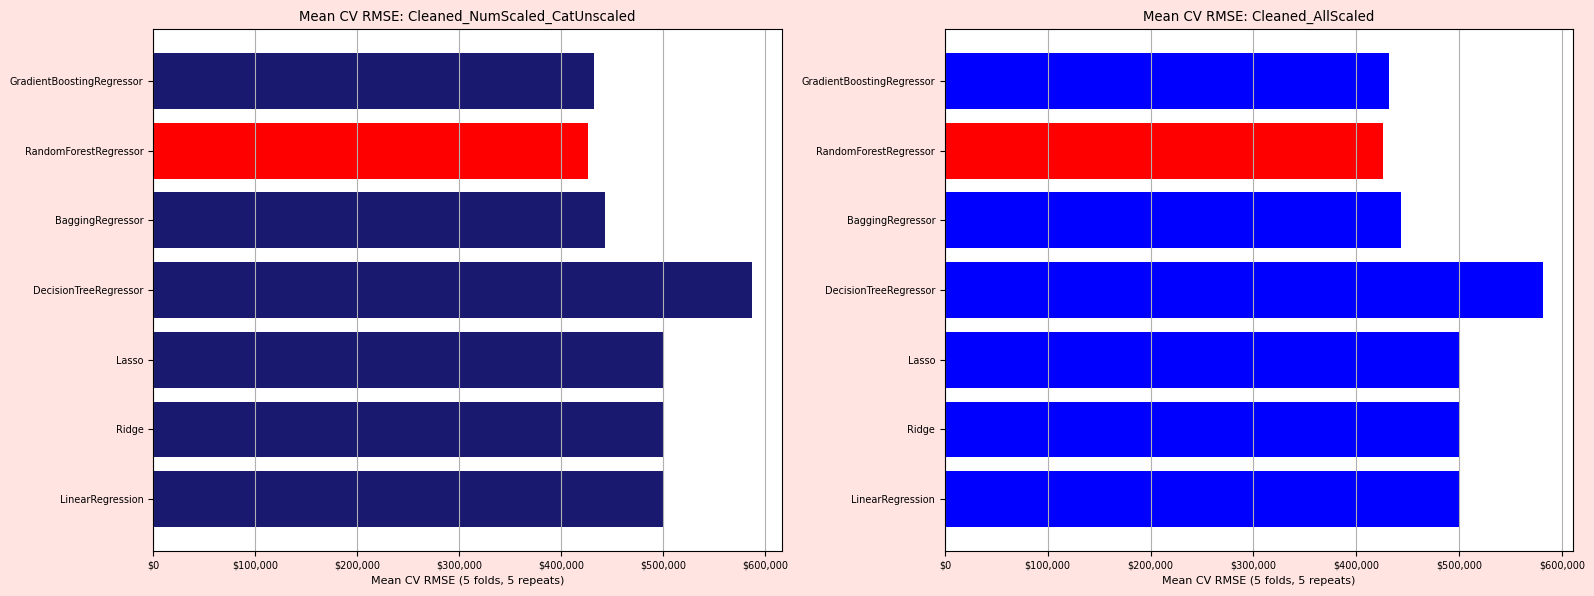

In [112]:


# Assuming baseline_results_df_1a and baseline_results_df_1b are defined DataFrames
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.patch.set_facecolor(f'{plot_patch_color}')

# Plot the bar charts using the function
plot_bar_chart(axes[0], baseline_results_df_1a)
plot_bar_chart(axes[1], baseline_results_df_1b, color_other='blue')

plt.tight_layout()
plt.show()


### <font color='gold'>Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

<font color='magenta'>

### **Amendments to cleaned dataset from Milestone 1**

Our initial Milestone 1 contained 19 features. We subsequently revised this by removing the following:
- `unitcnt`: We figured this feature was too niche, providing valuable information for apartment buildings only, but the dataset only had a few number of apartment buildings so the majority of the feature had a value of '1'. Not a lot of variance was provided by this feature.
- `propertylandusetypeid`: After doing more research online as to what this feature provides to the dataset, we realized that the information provided by this feature is in some part repeated in `propertycountylandusecode`. Because of the assumed redundancy, we dropped it. 
- `regionidcounty`: this feature contained only SOME number of unique values, so we figured it doesn't provide as much information as `regionidzip`. That is why we decided to remove the county id and keep the zip id.

### **Repeated K-fold Reasoning**

For our general `run_model` function that we use for each model to obtain the cross-validation MSE values, we followed the assignment instructions to use 5 folds and 5-repeats instead of the defalut 10 repeats. It's likely that using n_repeats = 10 would have reduced the variance of our performance estimates.  But, we considered our instructions and the implied added run-time for our more complex ensemble method models.  


### **To scale or not to scale....**

- We compared baseline model performance using a fully-scaled & standardized feature set versus the same features set in which only the numeric features were scaled/standardized.
- Scaling categorical features can make model coefficients more difficult to interpret.
- Unscaled categorical features may preclude using principal component analysis (PCA) in subsequent analyses, because PCA is more effective when all features are on a similar scale.
- **Conclusion:** See horizontal bar plot above. There was no meaningful difference in baseline performance assessment between the feature sets, so we will proceed with a fully scaled & standardized feature set.


### **PERFORMANCE**

Not surprisingly, the ensemble methods performed substantially better than the linear regression family. The regression family displays consistently higher standard deviation, perhaps attributable to the fact that the regression family is unable to capture complex relationships between features and the target, in turn making these models more unstable than the ensemble methods. The higher standard deviation also indicates that there may be signs of underfitting with the regression family since a higher STD means that there is greater variability in the error of predictions made with these models. Surprisingly, Decision Tree Regressor performed the worst out of all the models, in terms of both mean CV MSE and STD CV MSE.


    

## Part 2: Feature Engineering [3 pts]

### 2. Instructions

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler`
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table.

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`.

In [113]:
df

,buildingqualitytypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,propertycountylandusecode,regionidzip,censustractandblock,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt
0,8,0,0,2,1,1,96116,60400000000000,5,7.0,6913,0,0,15509,0,1980,25381250
1,8,0,0,2,1,18,96050,60400000000000,8,9.0,9708,0,0,48665,0,2012,24345695
2,11,0,0,2,1,1,96086,60400000000000,7,5.0,8790,0,0,48497,0,1926,23858374
3,10,0,0,2,1,1,96086,60400000000000,6,7.0,9242,0,0,78374,0,1993,22589311
4,12,0,0,2,1,1,96116,60400000000000,5,6.0,7674,0,0,56367,0,1998,20203475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76897,8,0,0,2,0,7,96327,60400000000000,0,2.0,360,0,0,2007,0,1925,11089
76898,4,0,0,7,0,0,96090,60400000000000,2,1.0,680,0,0,2167,0,1923,10504
76899,8,0,0,2,0,48,97108,61100000000000,2,1.0,500,1,0,5200,4,1939,9242
76900,4,0,0,7,0,0,96040,60400000000000,2,1.0,589,0,0,3249,0,1955,3254


In [114]:
df_2 = df.copy()
df_2.columns

Index(['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa',
       'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode',
       'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt'],
      dtype='object')

### <font color='gold'>2. Adding New Features

#### 2. New Feature:  `floor_area_ratio`

In [115]:
df_2['floor_area_ratio'] = df_2['calculatedfinishedsquarefeet'] / df_2['lotsizesquarefeet']
df_2['floor_area_ratio'].describe()

count    76902.000000
mean         0.250045
std          0.205792
min          0.000176
25%          0.143437
50%          0.211449
75%          0.305554
max         10.444915
Name: floor_area_ratio, dtype: float64

#### ~~2. New Feature: `finishedsqft_squared`~~

In [116]:
df_2['finishedsqft_squared'] = df_2['calculatedfinishedsquarefeet'] ** 2
df_2['finishedsqft_squared'].describe()

count    7.690200e+04
mean     4.068006e+06
std      6.570964e+06
min      1.638400e+04
25%      1.397124e+06
50%      2.374681e+06
75%      4.456321e+06
max      4.808810e+08
Name: finishedsqft_squared, dtype: float64

#### 2. New Feature: `property_age` (years)

In [117]:
current_year = 2016
# print(f"Current year: {current_year}")

df_2['property_age'] = current_year - df_2['yearbuilt']
df_2['property_age'].describe()

count    76902.000000
mean        47.486671
std         23.703547
min          0.000000
25%         29.000000
50%         46.000000
75%         63.000000
max        192.000000
Name: property_age, dtype: float64

#### 2. New Feature: `neighborhood_age`

In [118]:
#  Current year minus Average yearbuilt for each regionidzip
df_2['Neighborhood_Age'] = current_year - df_2.groupby('regionidzip')['yearbuilt'].transform('mean')

# print(df_2.head().to_markdown(index=False, numalign="left", stralign="left"))
# print(df_2.info())

#### ~~2. New Feature 3:  `yearbuilt_squared`~~

In [119]:
df_2['yearbuilt_squared'] = df_2['yearbuilt'] ** 2

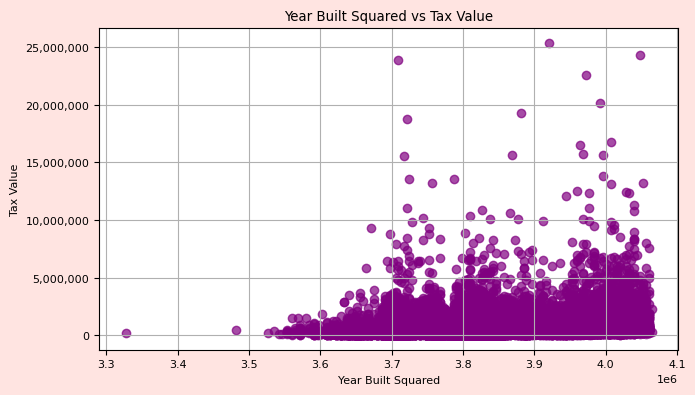

In [120]:

font_size = 8
plt.rcParams.update({"font.size": font_size})
plt.figure(figsize = (7, 4))
plt.gcf().patch.set_facecolor(f'{plot_patch_color}')

plt.scatter(df_2['yearbuilt_squared'], df_2['taxvaluedollarcnt'], c = 'purple' , alpha = 0.7)
plt.title('Year Built Squared vs Tax Value', fontstyle = 'normal',)
plt.xlabel('Year Built Squared')
plt.ylabel('Tax Value')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid()
plt.tight_layout()




<font color = 'magenta'> The relationship between a property's age (`yearbuilt`) and `taxvaluedollarcnt` is not always linear, so a polynomial feature might better capture the relationship. 

Older homes may not appreciate in value as fast as newer homes, and they are still highly unlikely to lose value, especially in the slice of the California homes represented by this dataset. 

In some cases, very old houses (historic properties) can appreciate in value due to their unique character, location, or historical significance. This creates a U-shaped or curved relationship.

Initially we added a squared term (yearbuilt_squared) to allow our models to fit a curve, but we still found  It can capture this non-linear relationship, where the effect of yearbuilt on taxvaluedollarcnt changes as yearbuilt increases.

#### 2. New Feature 4: `sqft_bdrmcnt`

In [121]:
df_2['sqft_bdrmcnt'] = df_2['calculatedfinishedsquarefeet'] * df_2['bedroomcnt']

<font color='magenta'>The value of additional square footage in a home might not be constant across different numbers of bedrooms.
For example, in a smaller home with fewer bedrooms, extra square footage could be more valuable as it provides much-needed living space.
In contrast, in a larger home with many bedrooms, additional square footage might be less valuable if it only contributes to even larger bedrooms or less essential spaces.


We capture the interaction by multiplying `calculatedfinishedsquarefeet` (total living area) by `bedroomcnt` (number of bedrooms) to create a new feature so our model can determine whether the impact of square footage on `taxvaluedollarcnt` changes depending on the number of bedrooms in the home.

In [122]:
# plt.scatter(df_2['calculatedfinishedsquarefeet'], df_2['taxvaluedollarcnt'], c = 'salmon' , alpha = 0.7)

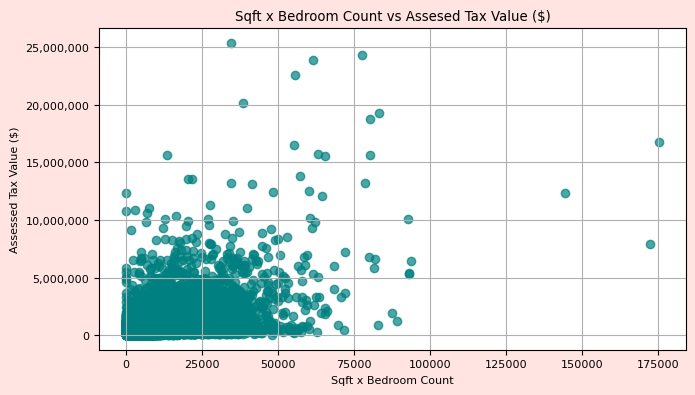

In [123]:
font_size = 8
plt.rcParams.update({"font.size": font_size})
plt.figure(figsize = (7, 4))
plt.gcf().patch.set_facecolor(f'{plot_patch_color}')
plt.scatter(df_2['sqft_bdrmcnt'], df_2['taxvaluedollarcnt'], c = 'teal' , alpha = 0.7)
plt.title('Sqft x Bedroom Count vs Assesed Tax Value ($)')
plt.xlabel('Sqft x Bedroom Count', fontsize = font_size)
plt.ylabel('Assessed Tax Value ($)', fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
#format in thousands with 0 decimal places 
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid()

plt.tight_layout()

#### 2. New Feature: `bedbathfactor`

In [124]:
df_2['bedbath_multiplier'] = df_2['calculatedbathnbr'] * df_2['bedroomcnt']
df_2['bedbath_multiplier'].describe()

count    76902.000000
mean         7.751294
std          6.173568
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max        130.000000
Name: bedbath_multiplier, dtype: float64

#### Log Transformation: `calculatedfinishedsquarefeet`

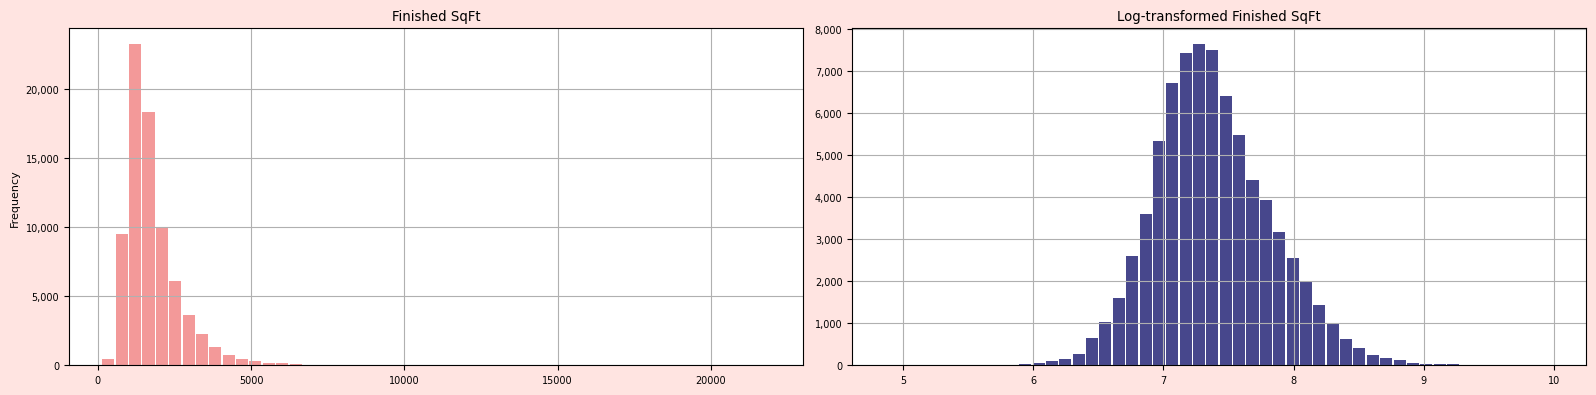

In [125]:

df_2['log_calculatedfinishedsquarefeet'] = np.log1p(df_2['calculatedfinishedsquarefeet'])

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (16, 4))
fig.patch.set_facecolor(f'{plot_patch_color}')

# Plot the first histogram (originally second)
df_2['calculatedfinishedsquarefeet'].hist(ax=axes[0], bins=50, color='lightcoral', alpha=0.8, rwidth=0.9)
# axes[0].set_xlabel('Assessed Tax Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Finished SqFt')
axes[0].tick_params(axis='both', labelsize=7)
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Plot the second histogram (originally first)
df_2['log_calculatedfinishedsquarefeet'].hist(ax=axes[1], bins=50, color='midnightblue', alpha=0.8, rwidth=0.9)
# axes[1].set_xlabel('Log-transformed Assessed Tax Value')
# axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-transformed Finished SqFt')
axes[1].tick_params(axis='both', labelsize=7)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

#### Log Transformation: `taxvaluedollarcnt`

In [126]:
df_2['taxvaluedollarcnt'].describe()

count    7.690200e+04
mean     4.875915e+05
std      6.254700e+05
min      1.000000e+03
25%      2.070000e+05
50%      3.582705e+05
75%      5.680000e+05
max      2.538125e+07
Name: taxvaluedollarcnt, dtype: float64

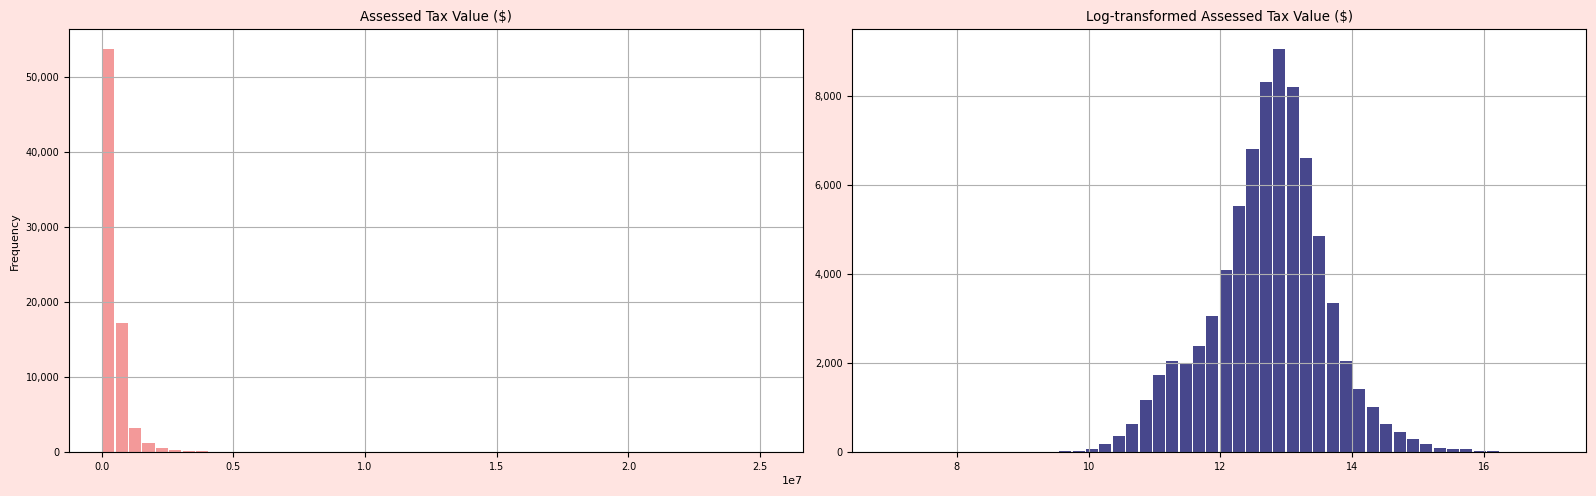

In [127]:

df_2['log_taxvaluedollarcnt'] = np.log1p(df_2['taxvaluedollarcnt'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 5))
fig.patch.set_facecolor('mistyrose')

# Plot the first histogram (originally second)
df_2['taxvaluedollarcnt'].hist(ax=axes[0], bins=50, color='lightcoral', alpha=0.8, rwidth=0.9)
# axes[0].set_xlabel('Assessed Tax Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Assessed Tax Value ($)')
axes[0].tick_params(axis='both', labelsize=7)
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Plot the second histogram (originally first)
df_2['log_taxvaluedollarcnt'].hist(ax=axes[1], bins=50, color='midnightblue', alpha=0.8, rwidth=0.9)
# axes[1].set_xlabel('Log-transformed Assessed Tax Value')
# axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-transformed Assessed Tax Value ($)')
axes[1].tick_params(axis='both', labelsize=7)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()



### 2. Train, Test & Split the updated cleaned dataset

In [128]:
df_2.columns

Index(['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa',
       'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode',
       'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt',
       'floor_area_ratio', 'finishedsqft_squared', 'property_age',
       'Neighborhood_Age', 'yearbuilt_squared', 'sqft_bdrmcnt',
       'bedbath_multiplier', 'log_calculatedfinishedsquarefeet',
       'log_taxvaluedollarcnt'],
      dtype='object')

In [129]:
#dropping both target variables (original and log scaled) to create feature set 

X_2 = df_2.drop(columns=['taxvaluedollarcnt', 'log_taxvaluedollarcnt', 'yearbuilt_squared', 'finishedsqft_squared'], axis = 1)
# X_2 = df_2.drop('taxvaluedollarcnt', axis = 1).drop('log_taxvaluedollarcnt', axis = 1)


# Set new target variable .... not sure which one to use
y_2_log = df_2['log_taxvaluedollarcnt']
y_2     = df_2['taxvaluedollarcnt']  # Using the original target variable for regression


X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
                                                            X_2, 
                                                            y_2, 
                                                            test_size       = 0.2, 
                                                            random_state    = random_state
                                                            )

In [130]:
# categorical_cols_2    = X_2.columns[:10].to_list()
# numeric_cols_2        = X_2.columns[10:].to_list()

# print('Categorical cols: ', categorical_cols_2)
# print('Numeric cols: ', numeric_cols_2)


### 2. Scale & Standardize

In [131]:
scaler     = StandardScaler()
X_2_train  = scaler.fit_transform(X_2_train)
X_2_test   = scaler.transform(X_2_test)

# print(f'X_train_scaled: {X_train_scaled}')
# print(f'X_test_scaled shape: {X_test_scaled.shape}')

In [132]:
X_2_train_scaled_df   = pd.DataFrame(X_2_train, columns = X_2.columns)
X_2_test_scaled_df    = pd.DataFrame(X_2_test, columns  = X_2.columns)
print(f'X_2_train_scaled_df shape: {X_2_train_scaled_df.shape}')
# print(X_2_train_scaled_df.describe().T)

feature_names_2       = X_2_train_scaled_df.columns
X_2_train_scaled_df.head(10)

X_2_train_scaled_df shape: (61521, 22)


,buildingqualitytypeid,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,propertycountylandusecode,regionidzip,censustractandblock,bedroomcnt,calculatedbathnbr,...,garagetotalsqft,lotsizesquarefeet,roomcnt,yearbuilt,floor_area_ratio,property_age,Neighborhood_Age,sqft_bdrmcnt,bedbath_multiplier,log_calculatedfinishedsquarefeet
0,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.207945,0.147336,0.340595,-0.940602,-0.318557,...,-0.517100,-0.176791,1.595221,0.567981,-0.241509,-0.567981,-1.236738,-0.570425,-0.607414,-0.235463
1,-1.970740,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.060932,-0.067695,-0.940602,-1.345462,...,-0.517100,-0.174766,-0.524707,-0.948190,-0.480215,0.948190,1.226949,-0.682574,-0.933004,-0.794098
2,-1.325709,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.160901,-0.067695,-0.940602,-1.345462,...,-0.517100,-0.194065,-0.524707,-2.674941,-0.168251,2.674941,3.206011,-0.681871,-0.933004,-0.790122
3,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.323527,0.118035,0.048959,2.614796,0.708348,...,2.073120,-0.183905,-0.524707,1.157604,1.025935,-1.157604,-1.558212,2.029047,1.671713,1.360756
4,-0.680679,-0.351085,-0.143718,1.228543,1.942743,-0.718415,-0.158603,-0.067695,-0.051752,-0.318557,...,-0.517100,-0.183407,-0.524707,-0.906074,-0.292301,0.906074,0.841602,-0.432612,-0.281825,-0.603505
5,-1.970740,-0.351085,-0.143718,-0.408179,-0.514736,0.668564,-0.095692,-0.067695,7.947892,1.735253,...,-0.517100,-0.182849,-0.524707,0.062591,1.929739,-0.062591,1.337111,7.807721,6.555559,2.160023
6,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,-0.872524,0.212545,-0.067695,0.837097,-0.318557,...,-0.517100,-0.173972,-0.524707,1.073372,-0.210918,-1.073372,-1.036920,0.014931,0.043765,-0.068335
7,0.609383,-0.351085,-0.143718,-0.408179,-0.514736,1.323527,0.140729,0.048959,-0.051752,0.194895,...,1.546144,-0.201274,-0.524707,0.778561,0.624171,-0.778561,-0.437763,-0.199524,-0.037632,0.085816
8,-1.970740,-0.351085,-0.143718,1.228543,-0.514736,-0.872524,-0.110917,-0.067695,-0.051752,-1.345462,...,-0.517100,-0.191673,-0.524707,-1.032422,-0.170841,1.032422,0.592408,-0.454760,-0.770209,-0.681583
9,-1.970740,-0.351085,-0.143718,-0.408179,-0.514736,0.668564,-0.018130,-0.067695,2.614796,1.735253,...,-0.517100,-0.139853,-0.524707,-1.158769,0.039962,1.158769,0.859928,2.034320,2.648483,1.364545


### <font color='gold'>2. Re-run the Models

- single loop to re-run all the models and summarize the results
- note the *Feature_Set* column in the summary table: it should contain the name of the revised dataset that includes the new features

In [133]:
## Dictionary of models with default parameters for bulk iteration 

dict_models_parameters = {
    LinearRegression:             linreg_params_default,
    Ridge:                        ridge_params_default,
    Lasso:                        lasso_params_default,
    DecisionTreeRegressor:        decision_tree_params_default,
    BaggingRegressor:             bagging_params_default,
    RandomForestRegressor:        random_forests_default_params,
    GradientBoostingRegressor:    gradient_boosting_default_params
}

In [134]:
results_dict_list_2 = []


# Loop through each model and its parameters
for model_class, params in dict_models_parameters.items():
    print(f"Running {model_class.__name__} with default parameters...\n")

    results_dict_2 = run_model(
        model_class,
        feature_set      = 'CleanedScaled_2',
        X_train          = X_2_train_scaled_df,
        y_train          = y_2_train,
        X_test           = X_2_test_scaled_df,
        y_test           = y_2_test,
        show_RMSE        = True,
        target_log_scale = False,
        **params
    )
    results_dict_list_2.append(results_dict_2)
    # print(f"Finished {model_name}.\n")

# Convert list of dictionaries to a DataFrame
baseline_results_df_2    = pd.DataFrame(results_dict_list_2)
baseline_results_df_2

Running LinearRegression with default parameters...

Inside run_model, cv_folds = 5
Running LinearRegression with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 782519.40it/s]


Model: LinearRegression | Feature Set: CleanedScaled_2 | CV RMSE = 499771.785 | STDVN = 36193.072
-----------------------------------------------------------------------------------------------
Running Ridge with default parameters...

Inside run_model, cv_folds = 5
Running Ridge with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 529583.84it/s]


Model: Ridge | Feature Set: CleanedScaled_2 | CV RMSE = 499539.503 | STDVN = 35873.861
-----------------------------------------------------------------------------------------------
Running Lasso with default parameters...

Inside run_model, cv_folds = 5
Running Lasso with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 733269.93it/s]


Model: Lasso | Feature Set: CleanedScaled_2 | CV RMSE = 499639.333 | STDVN = 35984.847
-----------------------------------------------------------------------------------------------
Running DecisionTreeRegressor with default parameters...

Inside run_model, cv_folds = 5
Running DecisionTreeRegressor with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 733269.93it/s]


Model: DecisionTreeRegressor | Feature Set: CleanedScaled_2 | CV RMSE = 592811.572 | STDVN = 38113.201
-----------------------------------------------------------------------------------------------
Running BaggingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 554802.12it/s]


Model: BaggingRegressor | Feature Set: CleanedScaled_2 | CV RMSE = 438461.495 | STDVN = 28417.216
-----------------------------------------------------------------------------------------------
Running RandomForestRegressor with default parameters...

Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 759837.68it/s]


Model: RandomForestRegressor | Feature Set: CleanedScaled_2 | CV RMSE = 420658.81 | STDVN = 27431.924
-----------------------------------------------------------------------------------------------
Running GradientBoostingRegressor with default parameters...

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: CleanedScaled_2


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 888623.73it/s]

Model: GradientBoostingRegressor | Feature Set: CleanedScaled_2 | CV RMSE = 428550.351 | STDVN = 27641.871
-----------------------------------------------------------------------------------------------


,model,Feature_Set,metric_label,Num_Features,mean_cv_mse,std_cv_mse,cv_folds,n_repeats,log_target,execution_time,timestamp
0,LinearRegression,CleanedScaled_2,RMSE,22,499771.785,36193.072,5,5,False,00:00:00,2025-04-13 15:38:58
1,Ridge,CleanedScaled_2,RMSE,22,499539.503,35873.861,5,5,False,00:00:00,2025-04-13 15:38:58
2,Lasso,CleanedScaled_2,RMSE,22,499639.333,35984.847,5,5,False,00:00:04,2025-04-13 15:39:03
3,DecisionTreeRegressor,CleanedScaled_2,RMSE,22,592811.572,38113.201,5,5,False,00:00:02,2025-04-13 15:39:05
4,BaggingRegressor,CleanedScaled_2,RMSE,22,438461.495,28417.216,5,5,False,00:00:13,2025-04-13 15:39:18
5,RandomForestRegressor,CleanedScaled_2,RMSE,22,420658.810,27431.924,5,5,False,00:02:13,2025-04-13 15:41:32
6,GradientBoostingRegressor,CleanedScaled_2,RMSE,22,428550.351,27641.871,5,5,False,00:00:31,2025-04-13 15:42:03


### 2. Summary

In [135]:
# combine the two dataframes
baseline_results_df_combined = pd.concat([baseline_results_df_1[7:], 
                                          baseline_results_df_2], 
                                        #   baseline_results_df_2b], 
                                          axis = 0
                                          )
baseline_results_df_combined.reset_index(drop = True, inplace = True)
baseline_results_df_combined

,model,Feature_Set,metric_label,Num_Features,mean_cv_mse,std_cv_mse,cv_folds,n_repeats,log_target,execution_time,timestamp
0,LinearRegression,Cleaned_AllScaled,RMSE,16,500625.579,32425.217,5,5,False,00:00:00,2025-04-13 15:37:22
1,Ridge,Cleaned_AllScaled,RMSE,16,500613.766,32428.303,5,5,False,00:00:00,2025-04-13 15:37:22
2,Lasso,Cleaned_AllScaled,RMSE,16,500610.240,32429.242,5,5,False,00:00:00,2025-04-13 15:37:23
3,DecisionTreeRegressor,Cleaned_AllScaled,RMSE,16,581923.490,32399.498,5,5,False,00:00:01,2025-04-13 15:37:24
4,BaggingRegressor,Cleaned_AllScaled,RMSE,16,443377.631,26175.413,5,5,False,00:00:07,2025-04-13 15:37:32
5,RandomForestRegressor,Cleaned_AllScaled,RMSE,16,426248.868,27792.347,5,5,False,00:01:08,2025-04-13 15:38:41
6,GradientBoostingRegressor,Cleaned_AllScaled,RMSE,16,432206.156,28127.990,5,5,False,00:00:15,2025-04-13 15:38:56
7,LinearRegression,CleanedScaled_2,RMSE,22,499771.785,36193.072,5,5,False,00:00:00,2025-04-13 15:38:58
8,Ridge,CleanedScaled_2,RMSE,22,499539.503,35873.861,5,5,False,00:00:00,2025-04-13 15:38:58
9,Lasso,CleanedScaled_2,RMSE,22,499639.333,35984.847,5,5,False,00:00:04,2025-04-13 15:39:03


In [136]:
baseline_results_df_combined_grouped = baseline_results_df_combined.groupby(['model', 'Feature_Set'])['mean_cv_mse']
baseline_results_df_combined_grouped = baseline_results_df_combined_grouped.mean().unstack()
baseline_results_df_combined_grouped


Feature_Set,CleanedScaled_2,Cleaned_AllScaled
model,,
BaggingRegressor,438461.495,443377.631
DecisionTreeRegressor,592811.572,581923.490
GradientBoostingRegressor,428550.351,432206.156
Lasso,499639.333,500610.240
LinearRegression,499771.785,500625.579
RandomForestRegressor,420658.810,426248.868
Ridge,499539.503,500613.766


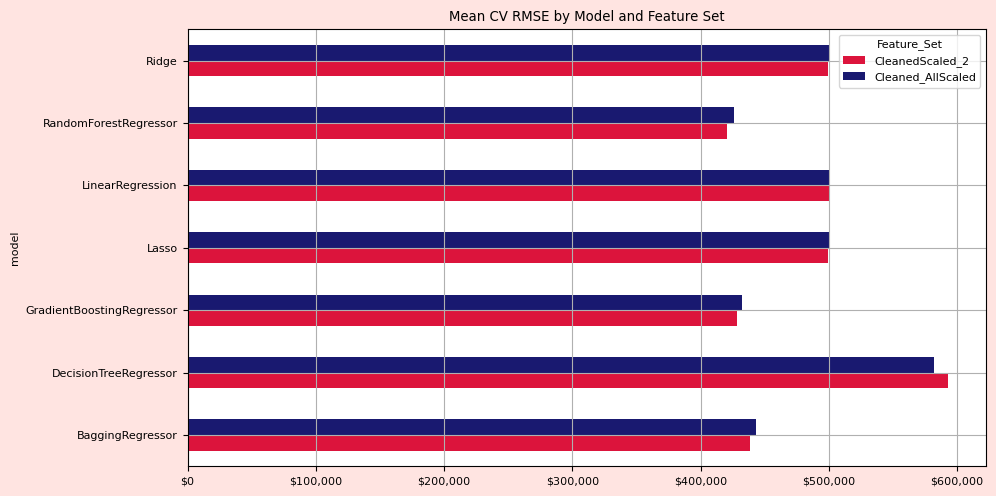

In [137]:
font_size = 8
plt.rcParams.update({"font.size": font_size})
baseline_results_df_combined_grouped.plot(
    kind = 'barh', 
    figsize = (10, 5), 
    color = ['crimson','midnightblue'], 
    fontsize = 8
    )

plt.gcf().patch.set_facecolor(f'{plot_patch_color}')

# plt.xlabel('Mean CV RMSE')
plt.title('Mean CV RMSE by Model and Feature Set')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.grid()
plt.tight_layout()

### <font color='gold'>Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



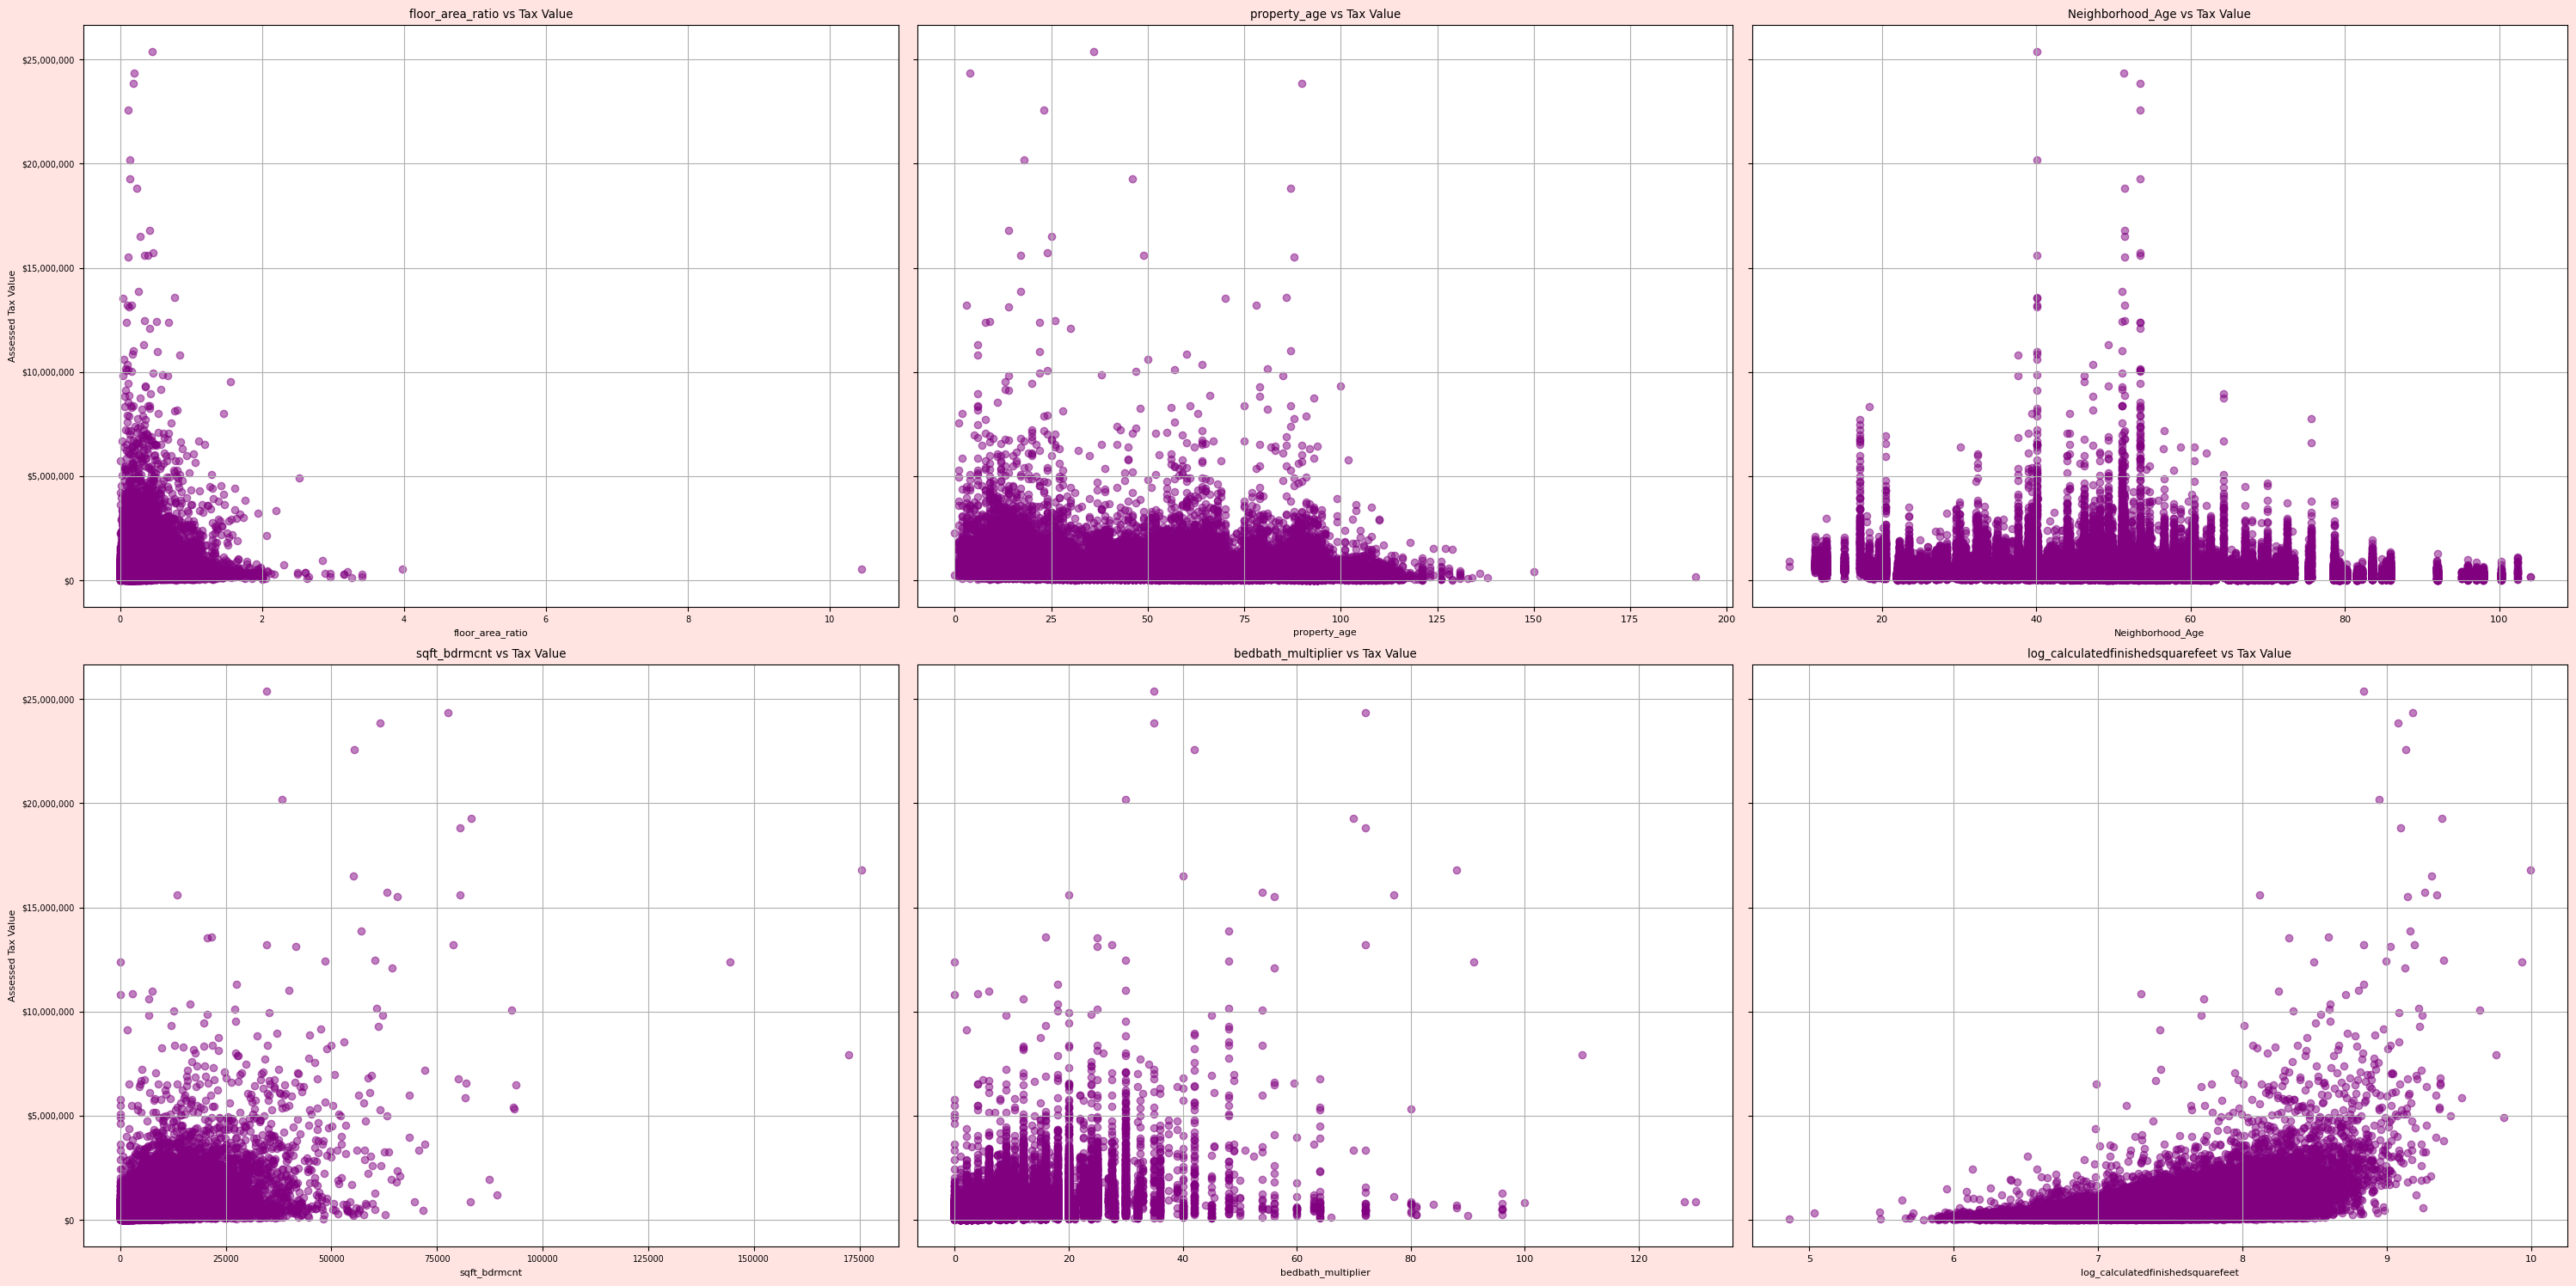

In [138]:
new_features = ['floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
fig.patch.set_facecolor(f'{plot_patch_color}')
ax = ax.flatten()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

for i, feature in enumerate(new_features):
    ax[i].scatter(df_2[new_features[i]], df_2['taxvaluedollarcnt'], c='purple', alpha=0.5 )
    ax[i].set_title(f'{feature} vs Tax Value')  
    ax[i].set_xlabel(feature)  
    if i % 3 != 0:  # Disable y-axis labels for all but the first column
        ax[i].set_yticklabels([])
    else:
        ax[i].set_ylabel('Assessed Tax Value')
        ax[i].tick_params(axis='both', labelsize=7)
        ax[i].yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    ax[i].grid()

plt.tight_layout()
plt.show()

<font color='magenta'> After applying 6 additional engineered features, all models showed marginal performance improvement compared to the initial cleaned dataset. 

Interestingly, standard deviation *worsened* for the linear models, Decision Tree Regressor, and Bagging Regressor. This means that while these models had improved predictability with the new features, they grew more unstable, possibly indicating signs of overfitting or underfitting. 

On the other hand, variance *improved* for both the Random Forest and Gradient Boosting Regressor models. Since Bagging Regressor is one of the ensemble methods that showed promise in Part 1, it is unexpected to see that the model worsened while the other ensemble methods improved.

Given the scatterplots above that show the new engineered features vs target, it seems like log_calculatedfinishedsquarefeet has a clear exponential relationship with the target. This is likely why the linear models performed worse (with lower STD) whereas ensemble methods like RF and gradient boosting were able to perform better than the linear models. </font>

## Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.

For each model:
- identify the **best-performing subset of features**.
- Re-run the model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


### Feature Selection by Model

#### Linear Regression

##### Linear: Finding best subset

All features: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']

Added: calculatedfinishedsquarefeet, CV Score (RMSE)(neg_mean_squared_error): 517,878.6223
Added: log_calculatedfinishedsquarefeet, CV Score (RMSE)(neg_mean_squared_error): 499,899.4227
Added: bedroomcnt, CV Score (RMSE)(neg_mean_squared_error): 495,716.3389
Added: buildingqualitytypeid, CV Score (RMSE)(neg_mean_squared_error): 493,323.6132
Added: calculatedbathnbr, CV Score (RMSE)(neg_mean_squared_error): 492,078.1368
Added: yearbuilt, CV Score (RMSE)(neg_mean_squared_error): 489,990.0906
Added: bedbath_multiplier, CV Score (RMSE)(neg_me

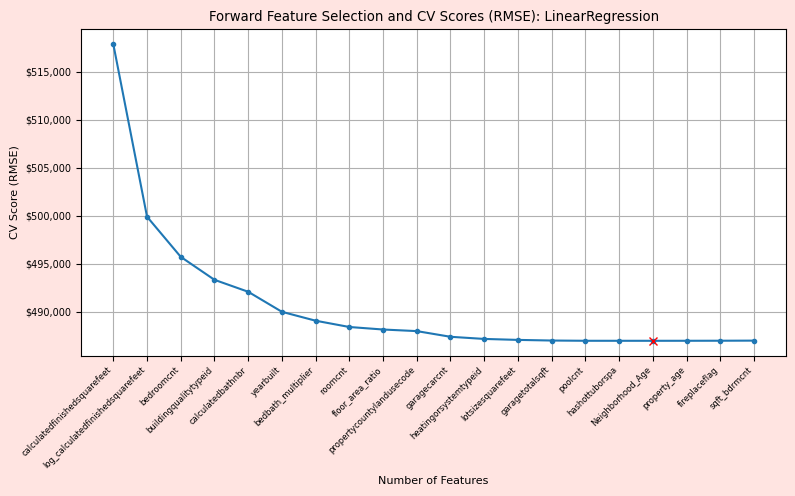

model: LinearRegression()
feature_set: CleanedScaled_2
direction: forward
selected_features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age', 'property_age', 'fireplaceflag', 'sqft_bdrmcnt']
best_scores: [517878.6223, 499899.4227, 495716.3389, 493323.6132, 492078.1368, 489990.0906, 489062.028, 488406.9848, 488145.1087, 487979.1018, 487387.0935, 487163.615, 487063.2241, 486997.2978, 486971.2862, 486970.0402, 486969.3965, 486971.7414, 486976.8416, 486987.6573]
best_feature_set: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountyland

In [139]:
results_dict_3_fwd_linreg = sequential_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model           = LinearRegression(),
    feature_set     = 'CleanedScaled_2',
    direction       = 'forward',
    max_features    = 20,  # Or a specific number
    scoring         = 'neg_mean_squared_error',
    show_RMSE       = True,
    n_jobs          = -1,
    verbose         = True,
    tol             = 1000,  # Stop if RMSE improvement is less than 1000
    patience        = 3     # Stop if no RMSE improvement for 3 consecutive steps
)

for key,val in results_dict_3_fwd_linreg.items():
    print(f"{key}: {val}")

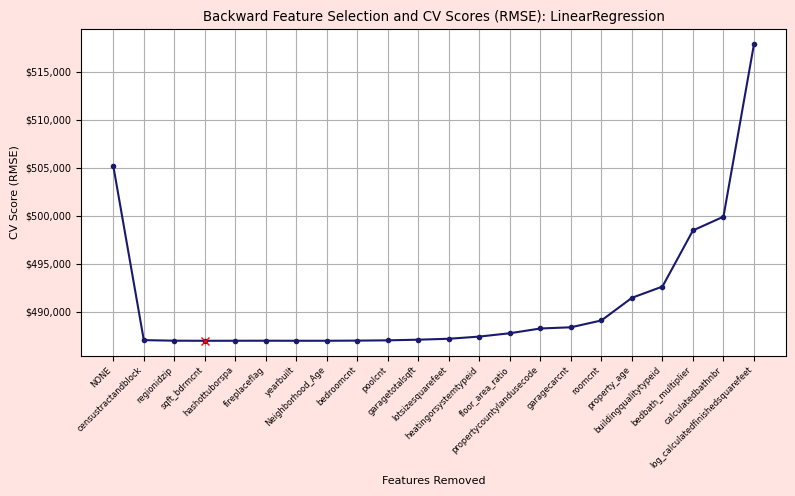

Best feature set: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']
CV score RMSE): 486,967.4330

Execution time: 00:00:41, finished at 2025-04-13 15:43:19
--------------------------------------------------------------------
Feature_Set: CleanedScaled_2
model: LinearRegression()
metric_label: RMSE
direction: backward
selected_features: ['NONE', 'censustractandblock', 'regionidzip', 'sqft_bdrmcnt', 'hashottuborspa', 'fireplaceflag', 'yearbuilt', 'Neighborhood_Age', 'bedroomcnt', 'poolcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'roomcnt', 'property_age', 'buildingqua

In [140]:
results_dict_3_bkwd_linreg = backward_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model       = LinearRegression(),
    feature_set = 'CleanedScaled_2',
    max_features= None,
    scoring     = 'neg_mean_squared_error',
    show_RMSE   = True,
    n_jobs      = -1,
    verbose     = False
)

for key,val in results_dict_3_bkwd_linreg.items():
    print(f"{key}: {val}")

##### Linear: Best Feature Subset Performance

In [141]:
best_seqSelector_linreg = get_best_sequential_selection(
    results_dict_3_fwd_linreg, 
    results_dict_3_bkwd_linreg, 
    'best_score', 
    smaller_is_better = True
)
# best_seqSelector_linreg

## Get the best feature subset by comparing the best CV RMSE scores from forward and backward selection
best_subset_linreg = best_seqSelector_linreg['best_feature_set']
print(f"Best subset of features: {best_subset_linreg}")

Score from dict1: 486969.3965, Score from dict2: 486967.433
Best feature set: backward, ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']
Best subset of features: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']


In [142]:
results_dict_3_subset_linreg = run_model(
    LinearRegression(),
    feature_set = 'best_subset_linreg',
    X_train     = X_2_train_scaled_df[best_subset_linreg],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_linreg],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **linreg_params_default
)
for key,val in results_dict_3_subset_linreg.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running LinearRegression with RMSE, feature set: best_subset_linreg


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 927943.36it/s]

Model: LinearRegression | Feature Set: best_subset_linreg | CV RMSE = 486031.956 | STDVN = 30885.708
-----------------------------------------------------------------------------------------------
model: LinearRegression
Feature_Set: best_subset_linreg
metric_label: RMSE
Num_Features: 19
mean_cv_mse: 486031.956
std_cv_mse: 30885.708
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:00:00
timestamp: 2025-04-13 15:43:20


#### Ridge Regression

All features: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']

Added: calculatedfinishedsquarefeet, CV Score (RMSE)(neg_mean_squared_error): 517,878.6207
Added: log_calculatedfinishedsquarefeet, CV Score (RMSE)(neg_mean_squared_error): 499,899.3722
Added: bedroomcnt, CV Score (RMSE)(neg_mean_squared_error): 495,716.2988
Added: buildingqualitytypeid, CV Score (RMSE)(neg_mean_squared_error): 493,323.5748
Added: calculatedbathnbr, CV Score (RMSE)(neg_mean_squared_error): 492,078.1002
Added: yearbuilt, CV Score (RMSE)(neg_mean_squared_error): 489,990.0573
Added: bedbath_multiplier, CV Score (RMSE)(neg_me

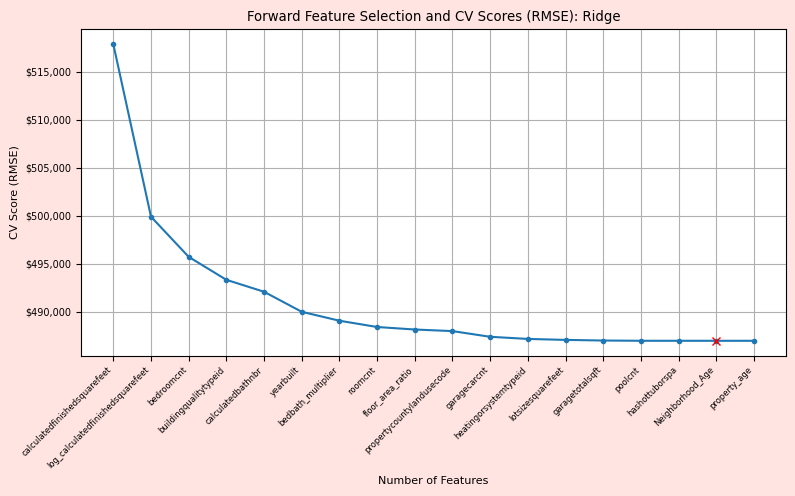

model: Ridge()
feature_set: CleanedScaled_2
direction: forward
selected_features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age', 'property_age']
best_scores: [517878.6207, 499899.3722, 495716.2988, 493323.5748, 492078.1002, 489990.0573, 489062.0188, 488406.9738, 488145.0937, 487979.0858, 487387.0789, 487163.6056, 487063.2132, 486997.2837, 486971.2792, 486970.0355, 486969.389, 486969.3892]
best_feature_set: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet

In [143]:
results_dict_3_fwd_ridge = sequential_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model       = Ridge(),
    feature_set = 'CleanedScaled_2',
    direction   = 'forward',
    max_features= 20,
    scoring     = 'neg_mean_squared_error',
    show_RMSE   = True,
    n_jobs      = -1,
    verbose     = True,
    tol        = 1000,  # Stop if RMSE improvement is less than 1000
)

for key,val in results_dict_3_fwd_ridge.items():
    print(f"{key}: {val}")

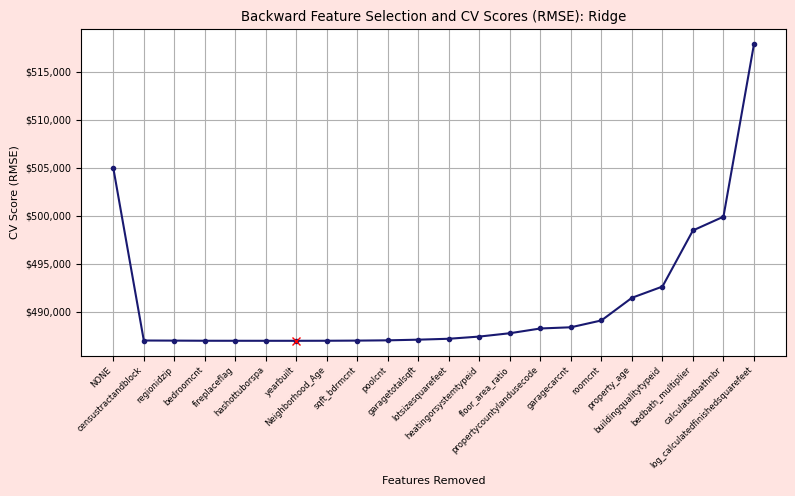

Best feature set: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']
CV score RMSE): 486,970.8048

Execution time: 00:00:40, finished at 2025-04-13 15:44:34
--------------------------------------------------------------------
Feature_Set: CleanedScaled_2
model: Ridge()
metric_label: RMSE
direction: backward
selected_features: ['NONE', 'censustractandblock', 'regionidzip', 'bedroomcnt', 'fireplaceflag', 'hashottuborspa', 'yearbuilt', 'Neighborhood_Age', 'sqft_bdrmcnt', 'poolcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'roomcnt', 'property_age', 'buildingqualitytypei

In [144]:
results_dict_3_bkwd_ridge = backward_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model       = Ridge(),
    feature_set = 'CleanedScaled_2',
    max_features= None,
    scoring     = 'neg_mean_squared_error',
    show_RMSE   = True,
    n_jobs      = -1,
    verbose     = False
)

for key,val in results_dict_3_bkwd_ridge.items():
    print(f"{key}: {val}")

##### Ridge: Best Feature Subset Performance

In [145]:
best_seqSelector_ridge = get_best_sequential_selection(
    results_dict_3_fwd_ridge, 
    results_dict_3_bkwd_ridge, 
    'best_score', 
    smaller_is_better = True
)
# best_seqSelector_ridge

best_subset_ridge = best_seqSelector_ridge['best_feature_set']
print(f"Best subset of features: {best_subset_ridge}")

Score from dict1: 486969.389, Score from dict2: 486970.8048
Best feature set: forward, ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age']
Best subset of features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age']


In [146]:
results_dict_3_subset_ridge = run_model(
    Ridge(),
    feature_set = 'best_subset_ridge',
    X_train     = X_2_train_scaled_df[best_subset_ridge],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_ridge],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **ridge_params_default
)
for key,val in results_dict_3_subset_ridge.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running Ridge with RMSE, feature set: best_subset_ridge


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 521679.60it/s]

Model: Ridge | Feature Set: best_subset_ridge | CV RMSE = 486028.013 | STDVN = 30887.46
-----------------------------------------------------------------------------------------------
model: Ridge
Feature_Set: best_subset_ridge
metric_label: RMSE
Num_Features: 17
mean_cv_mse: 486028.013
std_cv_mse: 30887.46
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:00:00
timestamp: 2025-04-13 15:44:34


#### Lasso

All features: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'regionidzip', 'censustractandblock', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+14, tolerance: 1.965e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+14, tolerance: 1.945e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+14, toler


Execution time: 00:01:07
Timestamp: 2025-04-13 15:45:42
--------------------------------------------------------------------


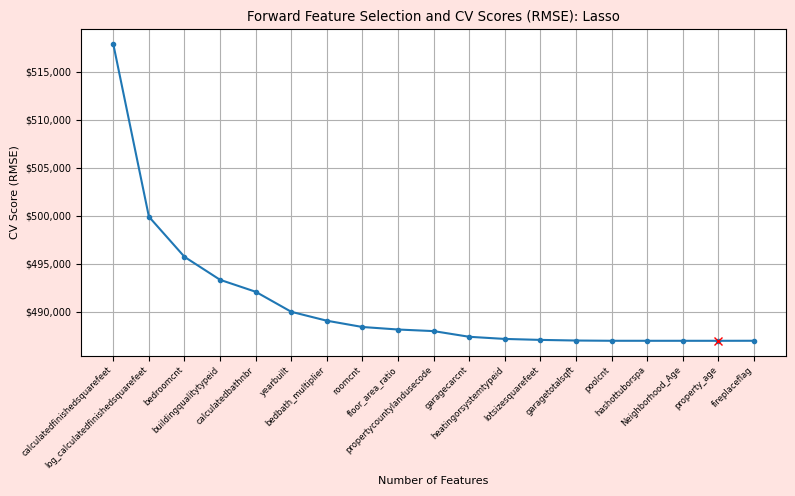

model: Lasso()
feature_set: CleanedScaled_2
direction: forward
selected_features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age', 'property_age', 'fireplaceflag']
best_scores: [517878.6228, 499899.4241, 495716.3412, 493323.6155, 492078.1393, 489990.0932, 489062.0332, 488406.9407, 488145.0627, 487979.1057, 487387.0961, 487163.6178, 487063.2267, 486997.3021, 486971.2911, 486970.0454, 486969.4014, 486969.4009, 486973.1168]
best_feature_set: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsy

In [147]:
results_dict_3_fwd_lasso = sequential_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model       = Lasso(),
    feature_set = 'CleanedScaled_2',
    direction   = 'forward',
    max_features= None,
    scoring     = 'neg_mean_squared_error',
    show_RMSE   = True,
    n_jobs      = -1,
    verbose     = False,
    tol        = 1000,  # Stop if RMSE improvement is less than 1000
)
for key,val in results_dict_3_fwd_lasso.items():
    print(f"{key}: {val}")

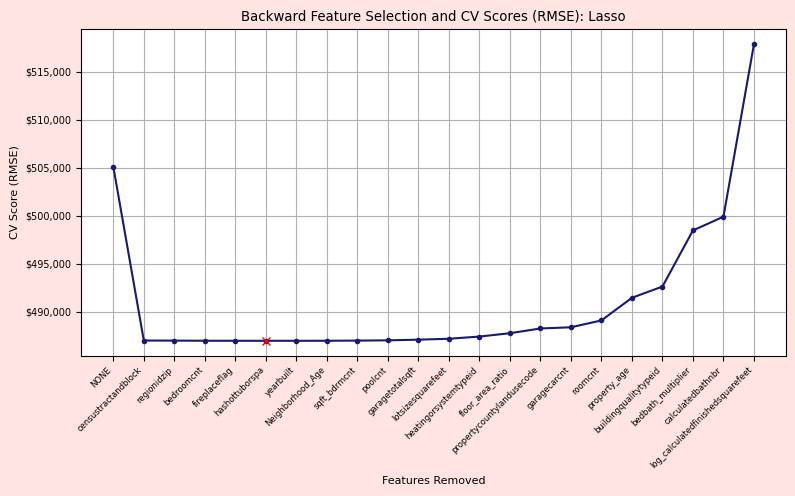

Best feature set: ['buildingqualitytypeid', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'propertycountylandusecode', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'bedbath_multiplier', 'log_calculatedfinishedsquarefeet']
CV score RMSE): 486,970.8917

Execution time: 00:02:05, finished at 2025-04-13 15:47:47
--------------------------------------------------------------------
Feature_Set: CleanedScaled_2
model: Lasso()
metric_label: RMSE
direction: backward
selected_features: ['NONE', 'censustractandblock', 'regionidzip', 'bedroomcnt', 'fireplaceflag', 'hashottuborspa', 'yearbuilt', 'Neighborhood_Age', 'sqft_bdrmcnt', 'poolcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'roomcnt', 'property_age', 'buildingqualitytypei

In [148]:
results_dict_3_bkwd_lasso = backward_feature_selection(
    X_2_train_scaled_df,
    y_2_train,
    model       = Lasso(),
    feature_set = 'CleanedScaled_2',
    max_features= None,
    scoring     = 'neg_mean_squared_error',
    show_RMSE   = True,
    n_jobs      = -1,
    verbose     = False
)

for key,val in results_dict_3_bkwd_lasso.items():
    print(f"{key}: {val}")

##### Lasso: Best Feature Subset Performance

In [149]:
best_seqSelector_lasso = get_best_sequential_selection(
    results_dict_3_fwd_lasso, 
    results_dict_3_bkwd_lasso, 
    'best_score', 
    smaller_is_better = True
)

## Get the best feature subset by comparing the best CV RMSE scores from forward and backward selection
best_subset_lasso = best_seqSelector_lasso['best_feature_set']
print(f"Best subset of features: {best_subset_lasso}")

Score from dict1: 486969.4009, Score from dict2: 486970.8917
Best feature set: forward, ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age', 'property_age']
Best subset of features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'yearbuilt', 'bedbath_multiplier', 'roomcnt', 'floor_area_ratio', 'propertycountylandusecode', 'garagecarcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'garagetotalsqft', 'poolcnt', 'hashottuborspa', 'Neighborhood_Age', 'property_age']


In [150]:
results_dict_3_subset_lasso = run_model(
    Lasso(),
    feature_set = 'best_subset_lasso',
    X_train     = X_2_train_scaled_df[best_subset_lasso],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_lasso],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **lasso_params_default
)
for key,val in results_dict_3_subset_lasso.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running Lasso with RMSE, feature set: best_subset_lasso


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.473e+14, tolerance: 2.014e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.604e+14, tolerance: 2.004e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.785e+14, toler

Model: Lasso | Feature Set: best_subset_lasso | CV RMSE = 486028.239 | STDVN = 30884.806
-----------------------------------------------------------------------------------------------
model: Lasso
Feature_Set: best_subset_lasso
metric_label: RMSE
Num_Features: 18
mean_cv_mse: 486028.239
std_cv_mse: 30884.806
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:00:05
timestamp: 2025-04-13 15:47:53


#### Decision Tree Regression

In [151]:
model               = DecisionTreeRegressor()
model.fit(X_2_train_scaled_df, y_2_train)

DecisionTreeRegressor()

In [152]:
################ RECURSIVE FEATURE ELIMINATION ################
rfe_decision_tree   = RFE(estimator = model, n_features_to_select = 10)
rfe_decision_tree.fit(X_2_train_scaled_df, y_2_train)

# Get selected features from RFE
selected_features_dt   = [feature_names_2[i] for i in range(len(feature_names_2)) if rfe_decision_tree.support_[i]]
print(f"{model}\nSelected features from Recursive Feature Elimination: {selected_features_dt}\n")


DecisionTreeRegressor()
Selected features from Recursive Feature Elimination: ['buildingqualitytypeid', 'regionidzip', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt', 'floor_area_ratio', 'property_age', 'Neighborhood_Age', 'sqft_bdrmcnt', 'log_calculatedfinishedsquarefeet']



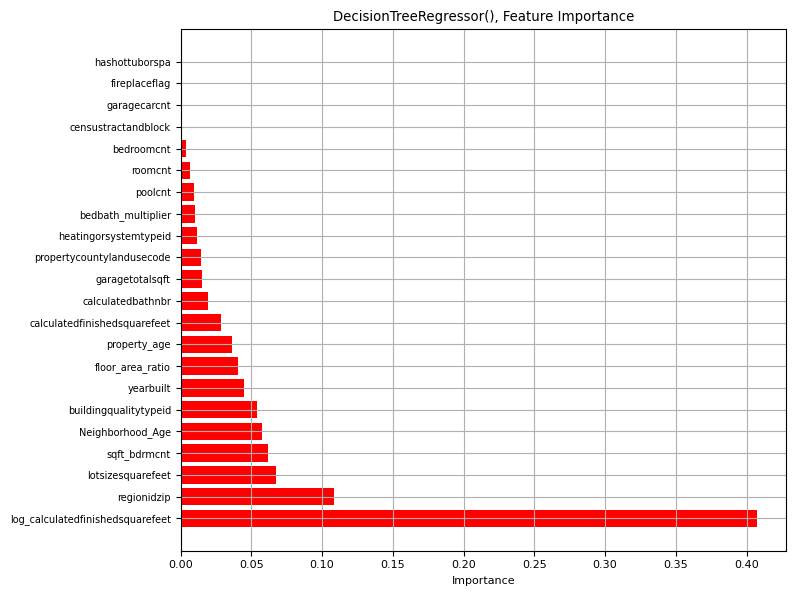

Feature ranking by Importance:
1. log_calculatedfinishedsquarefeet: 0.4075
2. regionidzip: 0.1083
3. lotsizesquarefeet: 0.0672
4. sqft_bdrmcnt: 0.0614
5. Neighborhood_Age: 0.0576
6. buildingqualitytypeid: 0.0538
7. yearbuilt: 0.0445
8. floor_area_ratio: 0.0406
9. property_age: 0.0365
10. calculatedfinishedsquarefeet: 0.0283
11. calculatedbathnbr: 0.0192
12. garagetotalsqft: 0.0148
13. propertycountylandusecode: 0.0143
14. heatingorsystemtypeid: 0.0118
15. bedbath_multiplier: 0.0103
16. poolcnt: 0.0093
17. roomcnt: 0.0068
18. bedroomcnt: 0.0037
19. censustractandblock: 0.0013
20. garagecarcnt: 0.0012
21. fireplaceflag: 0.0011
22. hashottuborspa: 0.0007


['buildingqualitytypeid',
 'regionidzip',
 'calculatedfinishedsquarefeet',
 'lotsizesquarefeet',
 'yearbuilt',
 'floor_area_ratio',
 'property_age',
 'Neighborhood_Age',
 'sqft_bdrmcnt',
 'log_calculatedfinishedsquarefeet']

In [ ]:
#################################### FEATURE IMPORTANCE ######################################################
# Get feature importances & indices of most important features

importances_dt  = model.feature_importances_
indices_dt      = np.argsort(importances_dt)[::-1]

# Sort the feature names and importances
sorted_feature_names    = [feature_names_2[i] for i in indices_dt]
sorted_importances      = importances_dt[indices_dt]

# Plot feature importances
plt.figure(figsize = (8, 6))
plt.barh(sorted_feature_names, sorted_importances, color = 'red', align = 'center')
plt.xlabel('Importance')
plt.yticks(fontsize = 7)
plt.title(f'{model}, Feature Importance')
plt.grid()
plt.tight_layout()
plt.show()

# Print feature ranking by importance
print("Feature ranking by Importance:")
for i in range(len(sorted_feature_names)):
    print(f"{i + 1}. {sorted_feature_names[i]}: {sorted_importances[i]:,.4f}")


In [200]:

best_subset_decision_tree = selected_features_dt
best_subset_decision_tree

['buildingqualitytypeid',
 'regionidzip',
 'calculatedfinishedsquarefeet',
 'lotsizesquarefeet',
 'yearbuilt',
 'floor_area_ratio',
 'property_age',
 'Neighborhood_Age',
 'sqft_bdrmcnt',
 'log_calculatedfinishedsquarefeet']

##### Decision Tree: Best Feature Subset Performance

In [154]:
results_dict_3_subset_decisiontree = run_model(
    DecisionTreeRegressor(),
    feature_set = 'best_subset_decision_tree',
    X_train     = X_2_train_scaled_df[best_subset_decision_tree],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_decision_tree],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **decision_tree_params_default
)
for key,val in results_dict_3_subset_decisiontree.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running DecisionTreeRegressor with RMSE, feature set: best_subset_decision_tree


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 639375.61it/s]

Model: DecisionTreeRegressor | Feature Set: best_subset_decision_tree | CV RMSE = 592096.145 | STDVN = 34295.106
-----------------------------------------------------------------------------------------------
model: DecisionTreeRegressor
Feature_Set: best_subset_decision_tree
metric_label: RMSE
Num_Features: 10
mean_cv_mse: 592096.145
std_cv_mse: 34295.106
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:00:02
timestamp: 2025-04-13 15:48:03


#### Bagging Regressor

##### Bagging Regressor: Embedded Method for Feature Selection

In [155]:
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators = 100, random_state = random_state)
bagging_model.fit(X_2_train_scaled_df, y_2_train)

# Get feature importances from each tree
all_importances = np.array([tree.feature_importances_ for tree in bagging_model.estimators_])

# Average across all trees
mean_importances = np.mean(all_importances, axis = 0)

sorted_idx = np.argsort(mean_importances)

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature':      feature_names_2,
    'Importance':   mean_importances
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

print(feature_importance_df)

                             Feature  Importance
0       calculatedfinishedsquarefeet    0.253175
1   log_calculatedfinishedsquarefeet    0.199824
2                        regionidzip    0.111707
3                   Neighborhood_Age    0.057157
4              buildingqualitytypeid    0.054036
5                  lotsizesquarefeet    0.053441
6                   floor_area_ratio    0.049850
7                       sqft_bdrmcnt    0.047752
8                       property_age    0.037271
9                          yearbuilt    0.035913
10                bedbath_multiplier    0.022885
11                 calculatedbathnbr    0.016844
12         propertycountylandusecode    0.016206
13                   garagetotalsqft    0.009396
14                        bedroomcnt    0.008473
15                           poolcnt    0.008413
16             heatingorsystemtypeid    0.006560
17                           roomcnt    0.005393
18                      garagecarcnt    0.002334
19                  

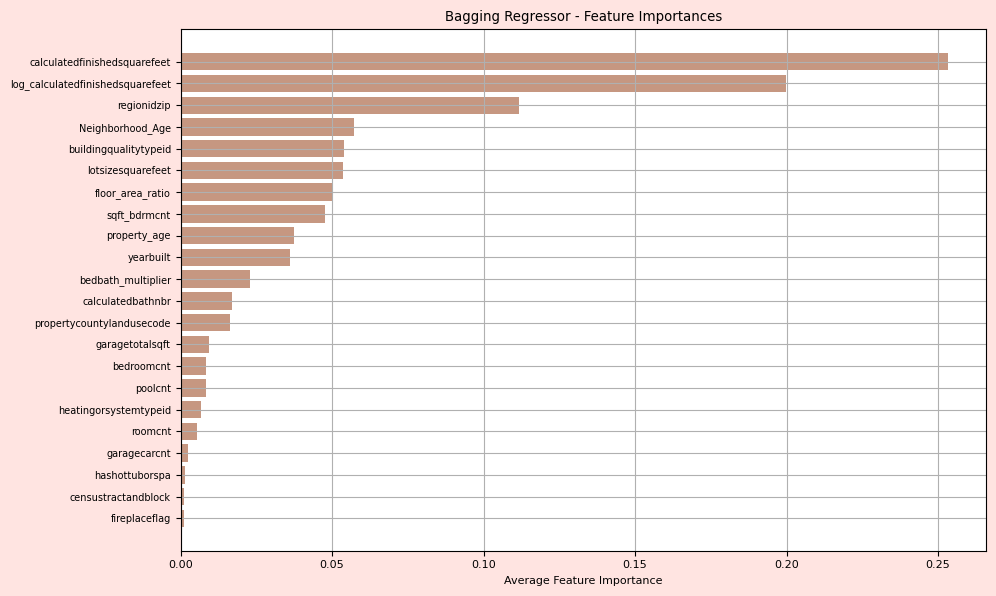

In [156]:
plt.figure(figsize = (10, 6))
plt.gcf().patch.set_facecolor(f'{plot_patch_color}')
plt.barh(range(len(mean_importances)), mean_importances[sorted_idx], align = 'center', color = 'sienna', alpha = 0.6)
plt.yticks(range(len(mean_importances)), np.array(feature_names_2)[sorted_idx], fontsize = 7)
plt.xlabel("Average Feature Importance")
plt.title("Bagging Regressor - Feature Importances")
plt.grid()
plt.tight_layout()
plt.show()

##### Bagging Regressor: Recursive Feature Elimination

In [157]:
# n_features          = 10

# # 1. Initialize the base estimator
# base_estimator = DecisionTreeRegressor(random_state = random_state) # Or RandomForestRegressor()

# # 2. Initialize the Bagging Regressor
# bagging_regressor = BaggingRegressor(base_estimator, random_state = random_state)

# # 3. Define a function to get feature importances from the BaggingRegressor
# def get_bagging_feature_importances(estimator):
#     importances = np.array([tree.feature_importances_ for tree in estimator.estimators_])
#     return np.mean(importances, axis=0)

# # 4. Initialize Recursive Feature Elimination (RFE)
# rfe = RFE(
#     estimator = bagging_regressor,
#     n_features_to_select = n_features,
#     importance_getter = get_bagging_feature_importances # Pass our custom function
# )

# # 5. Fit RFE on the training data
# rfe.fit(X_2_train_scaled_df, y_2_train)

# # 6. Get the selected feature subset
# selected_features_bagging = X_2_train_scaled_df.columns[rfe.support_].tolist()
# print(f"Selected features from Bagging Regressor with RFE: {selected_features_bagging}")

In [158]:
# # 7. Evaluate the model with the selected features (optional but recommended)
# X_train_selected_bagging    = X_2_train_scaled_df[selected_features_bagging]
# X_test_selected_bagging     = X_2_test_scaled_df[selected_features_bagging]

##### Bagging: Best Feature Subset Performance

In [159]:
best_subset_bagging = feature_importance_df['Feature'][:16].tolist()
print(f"Best subset of features: {best_subset_bagging}")

Best subset of features: ['calculatedfinishedsquarefeet', 'log_calculatedfinishedsquarefeet', 'regionidzip', 'Neighborhood_Age', 'buildingqualitytypeid', 'lotsizesquarefeet', 'floor_area_ratio', 'sqft_bdrmcnt', 'property_age', 'yearbuilt', 'bedbath_multiplier', 'calculatedbathnbr', 'propertycountylandusecode', 'garagetotalsqft', 'bedroomcnt', 'poolcnt']


In [160]:
results_dict_3_subset_bagging_2 = run_model(
    BaggingRegressor(),
    feature_set = 'best_subset_bagging(Embedded)',
    X_train     = X_2_train_scaled_df[best_subset_bagging],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_bagging],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **bagging_params_default
)
for key,val in results_dict_3_subset_bagging_2.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: best_subset_bagging(Embedded)


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 357875.77it/s]

Model: BaggingRegressor | Feature Set: best_subset_bagging(Embedded) | CV RMSE = 441716.018 | STDVN = 27059.244
-----------------------------------------------------------------------------------------------
model: BaggingRegressor
Feature_Set: best_subset_bagging(Embedded)
metric_label: RMSE
Num_Features: 16
mean_cv_mse: 441716.018
std_cv_mse: 27059.244
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:00:13
timestamp: 2025-04-13 15:48:56


In [161]:
# results_dict_3_subset_bagging = run_model(
#     BaggingRegressor(),
#     feature_set = 'best_subset_bagging(RFE)',
#     X_train     = X_train_selected_bagging,
#     y_train     = y_2_train,
#     X_test      = X_test_selected_bagging ,
#     y_test      = y_2_test,
#     show_RMSE   = True,
#     n_jobs      = -1,
#     **bagging_params_default
# )
# for key,val in results_dict_3_subset_bagging.items():
#     print(f"{key}: {val}")

#### Random Forest

##### Random Forest: Permutation Importance

In [162]:
model = RandomForestRegressor(n_estimators = 100, 
                              random_state = random_state
                              )
model.fit(X_2_train_scaled_df, y_2_train)



# PERMUTATION IMPORTANCE --- measures the change in the model's performance when the values of a feature are randomly shuffled. 
# It provides a more accurate measure of feature importance, especially when features are correlated.
result = permutation_importance(model, 
                                X_2_test_scaled_df, 
                                y_2_test, 
                                n_repeats       = 5, 
                                random_state    = random_state, 
                                n_jobs          = -1
                                )


# Get the importance scores and indices
perm_importances = result.importances_mean
indices_perm     = np.argsort(perm_importances)[::-1]

# Print feature ranking with names
print(f"{model} - Feature ranking, Mean Decrease in ACCURACY:")
for i in range(X_2_train_scaled_df.shape[1]):
    print(f"{i + 1}. {feature_names_2[indices_perm[i]]} {perm_importances[indices_perm[i]]:,.3f}")
print("-----------------------------  -------------------------------------------- ")



# Get feature importances and indices
importances = model.feature_importances_
indices     = np.argsort(importances)[::-1]

# Print feature ranking with names
print(f"{model} - Feature ranking, Mean Decrease in IMPURITY:")
for i in range(X_2_train_scaled_df.shape[1]):
    print(f"{i + 1}. {feature_names_2[indices[i]]}: {importances[indices[i]]:,.3f}")


RandomForestRegressor(random_state=42) - Feature ranking, Mean Decrease in ACCURACY:
1. regionidzip 0.357
2. log_calculatedfinishedsquarefeet 0.284
3. buildingqualitytypeid 0.239
4. calculatedfinishedsquarefeet 0.227
5. Neighborhood_Age 0.112
6. sqft_bdrmcnt 0.076
7. propertycountylandusecode 0.036
8. yearbuilt 0.018
9. property_age 0.016
10. floor_area_ratio 0.013
11. lotsizesquarefeet 0.011
12. roomcnt 0.007
13. heatingorsystemtypeid 0.004
14. bedbath_multiplier 0.003
15. garagetotalsqft 0.002
16. bedroomcnt 0.002
17. hashottuborspa 0.001
18. garagecarcnt 0.001
19. poolcnt 0.000
20. fireplaceflag 0.000
21. censustractandblock 0.000
22. calculatedbathnbr -0.000
-----------------------------  -------------------------------------------- 
RandomForestRegressor(random_state=42) - Feature ranking, Mean Decrease in IMPURITY:
1. calculatedfinishedsquarefeet: 0.241
2. log_calculatedfinishedsquarefeet: 0.213
3. regionidzip: 0.112
4. Neighborhood_Age: 0.057
5. buildingqualitytypeid: 0.053
6. l

##### Random Forests: Best Feature Subset Performance

In [163]:
### pick a subset and just run with it

best_subset_random_forest = [feature_names_2[i] for i in indices_perm[:10]]
print(f"Best subset of features: {best_subset_random_forest}")

Best subset of features: ['regionidzip', 'log_calculatedfinishedsquarefeet', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'Neighborhood_Age', 'sqft_bdrmcnt', 'propertycountylandusecode', 'yearbuilt', 'property_age', 'floor_area_ratio']


In [164]:
results_dict_3_subset_rf = run_model(
    RandomForestRegressor(),
    feature_set = 'best_subset_random_forest',
    X_train     = X_2_train_scaled_df[best_subset_random_forest],
    y_train     = y_2_train,
    X_test      = X_2_test_scaled_df[best_subset_random_forest],
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **random_forests_default_params
)
results_dict_3_subset_rf

Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: best_subset_random_forest


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 161319.38it/s]

Model: RandomForestRegressor | Feature Set: best_subset_random_forest | CV RMSE = 424937.123 | STDVN = 26796.536
-----------------------------------------------------------------------------------------------


{'model': 'RandomForestRegressor',
 'Feature_Set': 'best_subset_random_forest',
 'metric_label': 'RMSE',
 'Num_Features': 10,
 'mean_cv_mse': 424937.123,
 'std_cv_mse': 26796.536,
 'cv_folds': 5,
 'n_repeats': 5,
 'log_target': False,
 'execution_time': '00:01:30',
 'timestamp': '2025-04-13 15:51:39'}

#### Gradient Boosting Regression

GradientBoostingRegressor() Feature importances:
                             feature  importance
10      calculatedfinishedsquarefeet      0.3382
21  log_calculatedfinishedsquarefeet      0.2450
6                        regionidzip      0.1441
9                  calculatedbathnbr      0.0728
0              buildingqualitytypeid      0.0631
18                  Neighborhood_Age      0.0360
13                 lotsizesquarefeet      0.0160
8                         bedroomcnt      0.0148
19                      sqft_bdrmcnt      0.0142
15                         yearbuilt      0.0111
20                bedbath_multiplier      0.0106
17                      property_age      0.0071
16                  floor_area_ratio      0.0064
5          propertycountylandusecode      0.0058
4                            poolcnt      0.0043


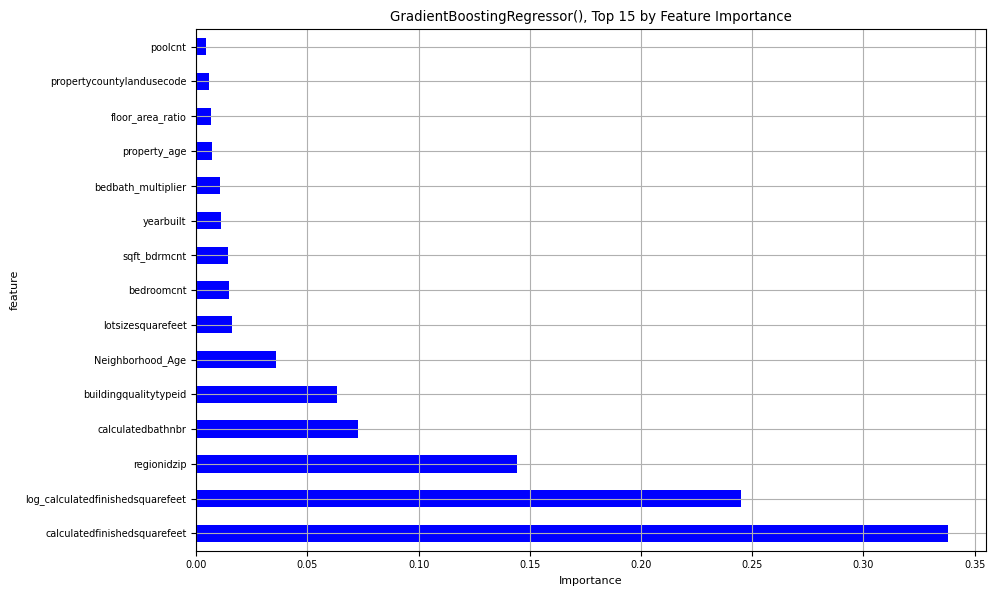

In [165]:

model = GradientBoostingRegressor()
model.fit(X_2_train_scaled_df, y_2_train)

feature_importance  = model.feature_importances_.round(4)
importance_df       = pd.DataFrame({'feature': X_2_train_scaled_df.columns, 'importance': feature_importance})
importance_df       = importance_df.sort_values(by = 'importance', ascending = False)

n_best              = 15
best_subset_gb_df   = importance_df.head(n_best) # n is the number of top features to select
# top_features ### best subset of features by importance score for gradient boosting regression


print(f"{model} Feature importances:\n{best_subset_gb_df}")
best_subset_gb_df.plot(kind = 'barh',
                    x        = 'feature', 
                    y        = 'importance', 
                    color    = 'blue', 
                    figsize  = (10, 6),
                    fontsize = 7, 
                    legend   = False)
plt.xlabel('Importance')
plt.title(f'{model}, Top {n_best} by Feature Importance')
plt.grid()
plt.tight_layout()
plt.show()

In [166]:
X_train_best_gb_df       = X_2_train_scaled_df[best_subset_gb_df['feature']]
X_test_best_gb_df        = X_2_test_scaled_df[best_subset_gb_df['feature']]

##### Gradient Boosting: Best Feature Subset Performance

In [167]:
print(f'X_train_best_gb_df shape: {X_train_best_gb_df.shape}\nX_test_best_gb_df shape: {X_test_best_gb_df.shape}')
print(f'y_2_train shape: {y_2_train.shape}\ny_2_test shape: {y_2_test.shape}')

X_train_best_gb_df shape: (61521, 15)
X_test_best_gb_df shape: (15381, 15)
y_2_train shape: (61521,)
y_2_test shape: (15381,)


In [168]:
results_dict_3_subset_gb = run_model(GradientBoostingRegressor,
                                feature_set = 'best_subset_gradient_boosting', 
                                X_train     = X_train_best_gb_df, 
                                y_train     = y_2_train, 
                                X_test      = X_test_best_gb_df, 
                                y_test      = y_2_test, 
                                show_RMSE   = True, 
                               **gradient_boosting_default_params
                               )
results_dict_3_subset_gb

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: best_subset_gradient_boosting


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 546133.33it/s]

Model: GradientBoostingRegressor | Feature Set: best_subset_gradient_boosting | CV RMSE = 428221.899 | STDVN = 26797.851
-----------------------------------------------------------------------------------------------


{'model': 'GradientBoostingRegressor',
 'Feature_Set': 'best_subset_gradient_boosting',
 'metric_label': 'RMSE',
 'Num_Features': 15,
 'mean_cv_mse': 428221.899,
 'std_cv_mse': 26797.851,
 'cv_folds': 5,
 'n_repeats': 5,
 'log_target': False,
 'execution_time': '00:00:28',
 'timestamp': '2025-04-13 15:52:17'}

#### <font color='gold'>3. Summary

In [169]:
# combine dictionaries into list and then convert to DataFrame
results_dict_list_3 = [results_dict_3_subset_linreg,
                        results_dict_3_subset_ridge,
                        results_dict_3_subset_lasso,
                        results_dict_3_subset_decisiontree,
                        # results_dict_3_subset_bagging,
                        results_dict_3_subset_bagging_2,
                        results_dict_3_subset_rf,
                        results_dict_3_subset_gb
                       ]

results_df_3        = pd.DataFrame(results_dict_list_3)

combined_results_df_1_2_3 = pd.concat([baseline_results_df_combined, results_df_3], axis = 0)
combined_results_df_1_2_3.reset_index(drop = True, inplace = True)
combined_results_df_1_2_3


,model,Feature_Set,metric_label,Num_Features,mean_cv_mse,std_cv_mse,cv_folds,n_repeats,log_target,execution_time,timestamp
0,LinearRegression,Cleaned_AllScaled,RMSE,16,500625.579,32425.217,5,5,False,00:00:00,2025-04-13 15:37:22
1,Ridge,Cleaned_AllScaled,RMSE,16,500613.766,32428.303,5,5,False,00:00:00,2025-04-13 15:37:22
2,Lasso,Cleaned_AllScaled,RMSE,16,500610.240,32429.242,5,5,False,00:00:00,2025-04-13 15:37:23
3,DecisionTreeRegressor,Cleaned_AllScaled,RMSE,16,581923.490,32399.498,5,5,False,00:00:01,2025-04-13 15:37:24
4,BaggingRegressor,Cleaned_AllScaled,RMSE,16,443377.631,26175.413,5,5,False,00:00:07,2025-04-13 15:37:32
5,RandomForestRegressor,Cleaned_AllScaled,RMSE,16,426248.868,27792.347,5,5,False,00:01:08,2025-04-13 15:38:41
6,GradientBoostingRegressor,Cleaned_AllScaled,RMSE,16,432206.156,28127.990,5,5,False,00:00:15,2025-04-13 15:38:56
7,LinearRegression,CleanedScaled_2,RMSE,22,499771.785,36193.072,5,5,False,00:00:00,2025-04-13 15:38:58
8,Ridge,CleanedScaled_2,RMSE,22,499539.503,35873.861,5,5,False,00:00:00,2025-04-13 15:38:58
9,Lasso,CleanedScaled_2,RMSE,22,499639.333,35984.847,5,5,False,00:00:04,2025-04-13 15:39:03


In [170]:
combined_results_df_1_2_3_grouped = combined_results_df_1_2_3.groupby(['model', 'Feature_Set'])['mean_cv_mse']
combined_results_df_1_2_3_grouped = combined_results_df_1_2_3_grouped.mean()
combined_results_df_1_2_3_grouped

model                      Feature_Set                  
BaggingRegressor           CleanedScaled_2                  438461.495
                           Cleaned_AllScaled                443377.631
                           best_subset_bagging(Embedded)    441716.018
DecisionTreeRegressor      CleanedScaled_2                  592811.572
                           Cleaned_AllScaled                581923.490
                           best_subset_decision_tree        592096.145
GradientBoostingRegressor  CleanedScaled_2                  428550.351
                           Cleaned_AllScaled                432206.156
                           best_subset_gradient_boosting    428221.899
Lasso                      CleanedScaled_2                  499639.333
                           Cleaned_AllScaled                500610.240
                           best_subset_lasso                486028.239
LinearRegression           CleanedScaled_2                  499771.785
                    

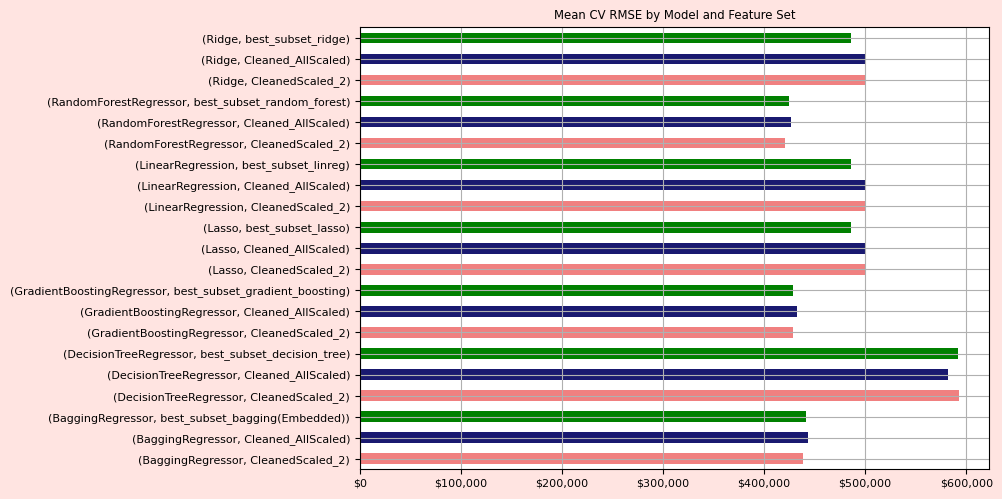

In [171]:

# Plotting the results
font_size = 7
plt.rcParams.update({"font.size": font_size})
plt.figure(figsize = (20, 5))
plt.gcf().patch.set_facecolor(f'{plot_patch_color}')

combined_results_df_1_2_3_grouped.plot(
        kind        = 'barh', 
        figsize     = (10, 5), 
        color       = ['lightcoral','midnightblue','green'], 
        fontsize    = 8
    )

# plt.xlabel('Mean CV RMSE')
plt.title('Mean CV RMSE by Model and Feature Set')
#remove y-axis label 
plt.ylabel('')


plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.grid()
plt.tight_layout()

#### Overlap across best feature subsets

In [172]:
best_subset_dict = {
    'Linear Regression': best_subset_linreg,
    'Ridge Regression': best_subset_ridge,
    'Lasso Regression': best_subset_lasso,
    'Decision Tree': best_subset_decision_tree,
    'Random Forest': best_subset_random_forest,
    'Gradient Boosting': best_subset_gb_df['feature'].tolist()
}

# for key, value in best_subset_dict.items():
#     print(f"{key}\nNum Features: {len(value)}: {value}\n")


common_features = set.intersection(*map(set, best_subset_dict.values()))
print(f"Common features across all models: {common_features}")


Common features across all models: {'calculatedfinishedsquarefeet', 'buildingqualitytypeid', 'yearbuilt', 'log_calculatedfinishedsquarefeet', 'Neighborhood_Age', 'floor_area_ratio'}


### <font color='gold'>Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> <font color='magenta'> 


### **Feature Selection: Linear vs Tree-based**
For the linear models, we compared forward & backward sequential selection to identify optimal feature subsets. For our linear family, <u>backwards selection</u> was preferred for the LinearRegressor model, while for RidgeRegressor and LassoRegressor, forward feature selection yielded smaller but only marginally better performing feature subsets.


For the tree-based models, a more bespoke approach was necessary because we cannot blindly rely on an algorithm to . We used a blend of techniques, including Recursive Feature Elimination, Permutation Importance and the Embedded method. 

**Decision Tree**:  We compared subsets produced via Recusive Feature Elimination as well as Feature Importance and decided to use the 10-feature subset from RFE. Despite what looked like a promising feature set, it produced by far the worst CV RMSE and makes us wonder why we even bothered. 

**Bagging Regressor**: b;aljbaljbl;j


Random Forest Regressor:
- We elected to use permutation importance (equivalently, the Mean Decrease in Accuracy) to determine relative importance scores for all 22 features. 
- We initialy limited the subset to the 10 best features by importance. We then both added and subtracted features incrementally, running our model each time, to test for marginal peformance improvement not unlike a parameter sweep. The conclusion: our RF model performed best using the top 10 features identified by the permutation importance approach. 

Gradient Boosting Regressor: 

**Feature Retention**
The following features were consistently retained:
- `calculatedfinishedsquarefeet`
- `buildingqualitytypeid`
- `property_age`
- `Neighborhood_Age`
- `floor_area_ratio`
- `yearbuilt`
- `log_calculatedfinishedsquarefeet`

With the exception of `calculatedfinishedsquarefeet` and `buildingqualitytypeid`, the features retained across all models included 5 of our engineered features. This suggests predictive power (namely, they seem to contribute consistently to model accuracy). If we had time, we could conduct tests of R-squared values to confirm. 

We do acknowledge the high correlation between these engineered features, which are derived from source features. 


## Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks.
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



### 4. Gradient Boosting Regression

In [174]:
params_gb_dict = gradient_boosting_default_params.copy()
params_gb_dict['max_features'] = None
params_gb_dict

{'n_estimators': 100,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 1.0,
 'max_features': None}

In [175]:
best_params_gb_baseline = results_dict_3_subset_gb

Running GradientBoostingRegressor with parameter sweep...




Sweeping learning_rate:   0%|          | 0/10 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 557753.19it/s]

Sweeping learning_rate:  10%|█         | 1/10 [00:27<04:07, 27.46s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 499165.775 | STDVN = 32077.966
-----------------------------------------------------------------------------------------------
learning_rate = 0.01: CV RMSE = 499,165.775
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 529583.84it/s]

Sweeping learning_rate:  20%|██        | 2/10 [00:54<03:38, 27.30s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 449561.078 | STDVN = 28403.313
-----------------------------------------------------------------------------------------------
learning_rate = 0.03: CV RMSE = 449,561.078
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 521679.60it/s]

Sweeping learning_rate:  30%|███       | 3/10 [01:21<03:11, 27.32s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 437015.869 | STDVN = 28121.966
-----------------------------------------------------------------------------------------------
learning_rate = 0.049999999999999996: CV RMSE = 437,015.869
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 532272.08it/s]

Sweeping learning_rate:  40%|████      | 4/10 [01:49<02:43, 27.27s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 431764.953 | STDVN = 28421.694
-----------------------------------------------------------------------------------------------
learning_rate = 0.06999999999999999: CV RMSE = 431,764.953
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 463971.68it/s]

Sweeping learning_rate:  50%|█████     | 5/10 [02:16<02:16, 27.30s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 429090.466 | STDVN = 28408.894
-----------------------------------------------------------------------------------------------
learning_rate = 0.08999999999999998: CV RMSE = 429,090.466
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 492289.20it/s]

Sweeping learning_rate:  60%|██████    | 6/10 [02:43<01:49, 27.27s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 427724.4 | STDVN = 27870.202
-----------------------------------------------------------------------------------------------
learning_rate = 0.10999999999999999: CV RMSE = 427,724.400
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 501711.00it/s]

Sweeping learning_rate:  70%|███████   | 7/10 [03:10<01:21, 27.23s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 424743.059 | STDVN = 26494.195
-----------------------------------------------------------------------------------------------
learning_rate = 0.12999999999999998: CV RMSE = 424,743.059
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 582542.22it/s]

Sweeping learning_rate:  80%|████████  | 8/10 [03:38<00:54, 27.25s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 424366.776 | STDVN = 26258.683
-----------------------------------------------------------------------------------------------
learning_rate = 0.14999999999999997: CV RMSE = 424,366.776
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 511500.49it/s]

Sweeping learning_rate:  90%|█████████ | 9/10 [04:05<00:27, 27.26s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 424879.687 | STDVN = 24864.222
-----------------------------------------------------------------------------------------------
learning_rate = 0.16999999999999998: CV RMSE = 424,879.687
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 511500.49it/s]

Sweeping learning_rate: 100%|██████████| 10/10 [04:32<00:00, 27.27s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 424536.988 | STDVN = 25696.653
-----------------------------------------------------------------------------------------------
learning_rate = 0.18999999999999997: CV RMSE = 424,536.988


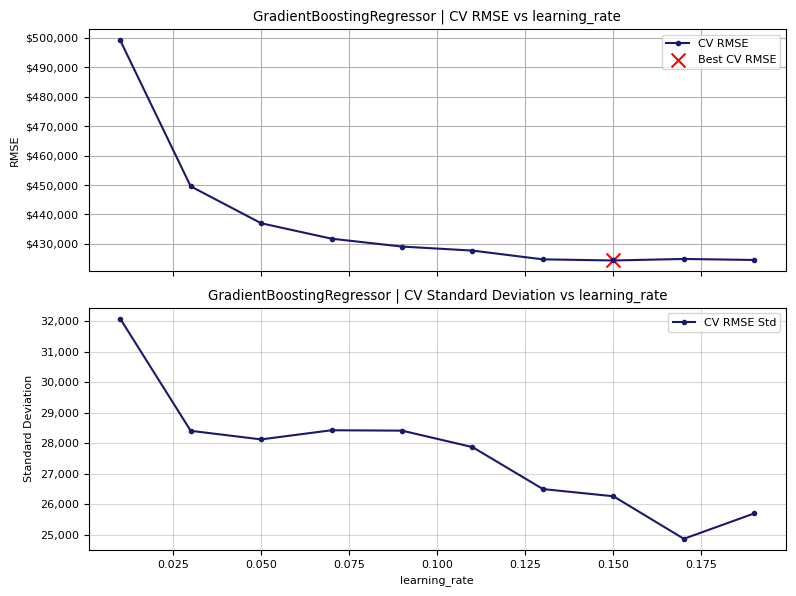

Executed successfully at: 2025-04-13 15:56:50
Results: {'n_estimators': 100, 'learning_rate': 0.14999999999999997, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0, 'max_features': None, 'Test_Param': 'learning_rate', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 424366.776, 'cv_repeats': 5, 'execution_time': '00:04:32', 'timestamp': '2025-04-13 15:56:50'}


{'n_estimators': 100,
 'learning_rate': 0.14999999999999997,
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 1.0,
 'max_features': None,
 'Test_Param': 'learning_rate',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 424366.776,
 'cv_repeats': 5,
 'execution_time': '00:04:32',
 'timestamp': '2025-04-13 15:56:50'}

In [176]:
best_params_gb_learningrate = sweep_parameter(
    model           = GradientBoostingRegressor,
    Parameters      = params_gb_dict,
    param           = 'learning_rate',
    parameter_list  = np.arange(0.01, 0.21, 0.02).tolist(),
    X_train         = X_train_best_gb_df,
    y_train         = y_2_train,
    X_test          = X_test_best_gb_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)
best_params_gb_learningrate


In [177]:
params_gb_dict['learning_rate'] = best_params_gb_learningrate['learning_rate']
# print(params_gb_dict)

Running GradientBoostingRegressor with parameter sweep...




Sweeping n_estimators:   0%|          | 0/5 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 422812.90it/s]

Sweeping n_estimators:  20%|██        | 1/5 [02:15<09:01, 135.47s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 420277.413 | STDVN = 25512.139
-----------------------------------------------------------------------------------------------
n_estimators = 500: CV RMSE = 420,277.413
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 461927.75it/s]

Sweeping n_estimators:  40%|████      | 2/5 [04:44<07:10, 143.42s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 419829.19 | STDVN = 25502.528
-----------------------------------------------------------------------------------------------
n_estimators = 550: CV RMSE = 419,829.190
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 592415.82it/s]

Sweeping n_estimators:  60%|██████    | 3/5 [07:27<05:04, 152.41s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 420590.888 | STDVN = 25437.806
-----------------------------------------------------------------------------------------------
n_estimators = 600: CV RMSE = 420,590.888
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 470213.45it/s]

Sweeping n_estimators:  80%|████████  | 4/5 [10:26<02:43, 163.02s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 420112.42 | STDVN = 25177.289
-----------------------------------------------------------------------------------------------
n_estimators = 650: CV RMSE = 420,112.420
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 489988.79it/s]

Sweeping n_estimators: 100%|██████████| 5/5 [13:37<00:00, 163.41s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 420570.616 | STDVN = 25602.093
-----------------------------------------------------------------------------------------------
n_estimators = 700: CV RMSE = 420,570.616


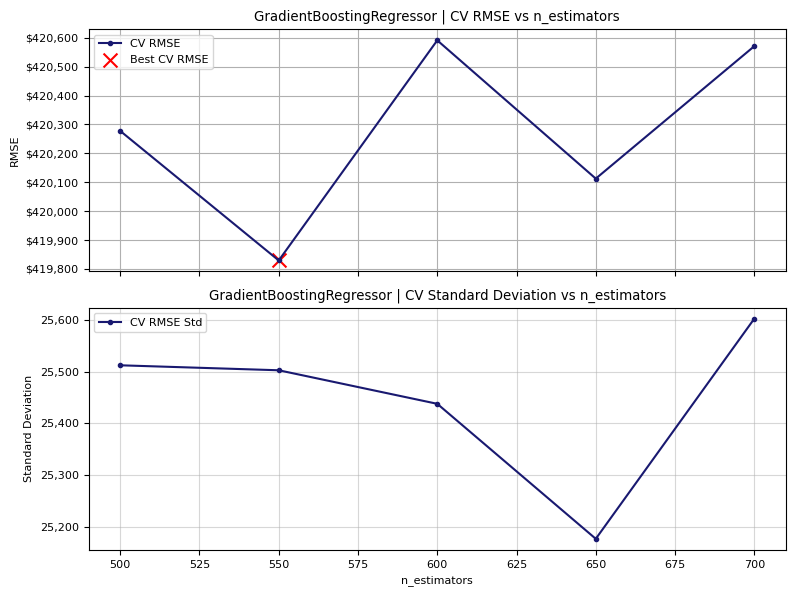

Executed successfully at: 2025-04-13 16:10:27
Results: {'n_estimators': 550, 'learning_rate': 0.14999999999999997, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0, 'max_features': None, 'Test_Param': 'n_estimators', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 419829.19, 'cv_repeats': 5, 'execution_time': '00:13:37', 'timestamp': '2025-04-13 16:10:27'}


{'n_estimators': 550,
 'learning_rate': 0.14999999999999997,
 'max_depth': 3,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 1.0,
 'max_features': None,
 'Test_Param': 'n_estimators',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 419829.19,
 'cv_repeats': 5,
 'execution_time': '00:13:37',
 'timestamp': '2025-04-13 16:10:27'}

In [178]:
best_params_gb_nestimators = sweep_parameter(
    model           = GradientBoostingRegressor,
    Parameters      = params_gb_dict,
    param           = 'n_estimators',
    parameter_list  = list(np.arange(500, 701, 50)),
    X_train         = X_train_best_gb_df,
    y_train         = y_2_train,
    X_test          = X_test_best_gb_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)
best_params_gb_nestimators

In [179]:
params_gb_dict['n_estimators'] = best_params_gb_nestimators['n_estimators']


Running GradientBoostingRegressor with parameter sweep...




Sweeping max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 463971.68it/s]

Sweeping max_depth:  20%|██        | 1/5 [02:29<09:56, 149.24s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 420277.244 | STDVN = 24976.294
-----------------------------------------------------------------------------------------------
max_depth = 3: CV RMSE = 420,277.244
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 190997.45it/s]

Sweeping max_depth:  40%|████      | 2/5 [05:48<08:55, 178.38s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417902.488 | STDVN = 24880.208
-----------------------------------------------------------------------------------------------
max_depth = 4: CV RMSE = 417,902.488
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 543303.63it/s]

Sweeping max_depth:  60%|██████    | 3/5 [10:20<07:23, 221.54s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 419087.708 | STDVN = 27281.504
-----------------------------------------------------------------------------------------------
max_depth = 5: CV RMSE = 419,087.708
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 543303.63it/s]

Sweeping max_depth:  80%|████████  | 4/5 [15:06<04:06, 246.96s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 421987.735 | STDVN = 24826.217
-----------------------------------------------------------------------------------------------
max_depth = 6: CV RMSE = 421,987.735
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 123798.82it/s]

Sweeping max_depth: 100%|██████████| 5/5 [21:20<00:00, 256.16s/it]


Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 425935.234 | STDVN = 29714.919
-----------------------------------------------------------------------------------------------
max_depth = 7: CV RMSE = 425,935.234


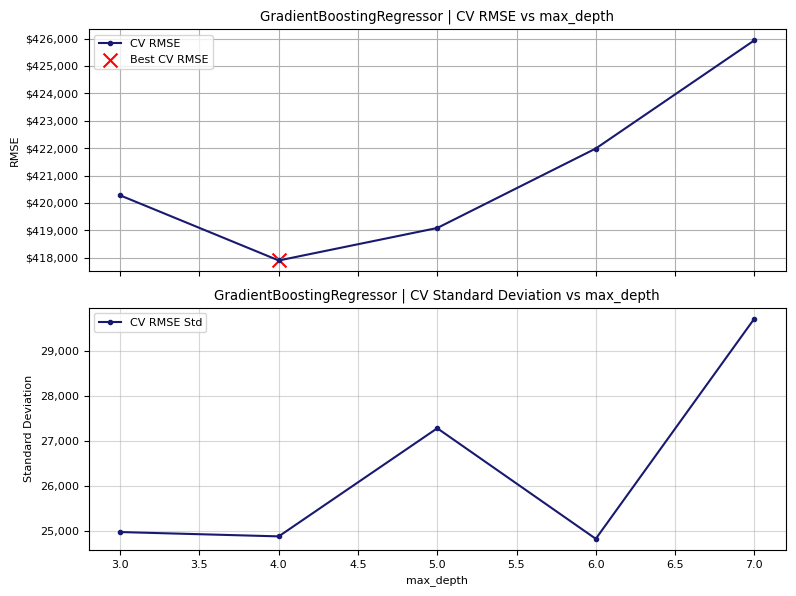

Executed successfully at: 2025-04-13 16:31:48
Results: {'n_estimators': 550, 'learning_rate': 0.14999999999999997, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0, 'max_features': None, 'Test_Param': 'max_depth', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 417902.488, 'cv_repeats': 5, 'execution_time': '00:21:20', 'timestamp': '2025-04-13 16:31:48'}


{'n_estimators': 550,
 'learning_rate': 0.14999999999999997,
 'max_depth': 4,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 1.0,
 'max_features': None,
 'Test_Param': 'max_depth',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 417902.488,
 'cv_repeats': 5,
 'execution_time': '00:21:20',
 'timestamp': '2025-04-13 16:31:48'}

In [180]:
best_params_gb_max_depth = sweep_parameter(
    model           = GradientBoostingRegressor,
    Parameters      = params_gb_dict,
    param           = 'max_depth',
    parameter_list  = list(np.arange(3, 8, 1)),
    X_train         = X_train_best_gb_df,
    y_train         = y_2_train,
    X_test          = X_test_best_gb_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)
best_params_gb_max_depth

In [181]:
params_gb_dict['max_depth'] = best_params_gb_max_depth['max_depth']

Running GradientBoostingRegressor with parameter sweep...




Sweeping max_features:   0%|          | 0/10 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 569878.26it/s]

Sweeping max_features:  10%|█         | 1/10 [01:31<13:39, 91.09s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 416039.744 | STDVN = 24730.884
-----------------------------------------------------------------------------------------------
max_features = 6: CV RMSE = 416,039.744
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 492289.20it/s]

Sweeping max_features:  20%|██        | 2/10 [03:18<13:26, 100.75s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 416174.565 | STDVN = 25483.79
-----------------------------------------------------------------------------------------------
max_features = 7: CV RMSE = 416,174.565
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 595781.82it/s]

Sweeping max_features:  30%|███       | 3/10 [05:27<13:14, 113.45s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 416218.512 | STDVN = 27365.027
-----------------------------------------------------------------------------------------------
max_features = 8: CV RMSE = 416,218.512
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 579323.76it/s]

Sweeping max_features:  40%|████      | 4/10 [07:36<11:58, 119.83s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417315.663 | STDVN = 26415.412
-----------------------------------------------------------------------------------------------
max_features = 9: CV RMSE = 417,315.663
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 182678.75it/s]

Sweeping max_features:  50%|█████     | 5/10 [10:16<11:11, 134.36s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417071.121 | STDVN = 23943.37
-----------------------------------------------------------------------------------------------
max_features = 10: CV RMSE = 417,071.121
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 718202.74it/s]

Sweeping max_features:  60%|██████    | 6/10 [13:06<09:44, 146.23s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 415248.987 | STDVN = 24863.37
-----------------------------------------------------------------------------------------------
max_features = 11: CV RMSE = 415,248.987
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 713317.01it/s]

Sweeping max_features:  70%|███████   | 7/10 [16:21<08:06, 162.21s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417201.447 | STDVN = 26530.3
-----------------------------------------------------------------------------------------------
max_features = 12: CV RMSE = 417,201.447
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 438734.73it/s]

Sweeping max_features:  80%|████████  | 8/10 [19:41<05:48, 174.18s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 418304.867 | STDVN = 24756.838
-----------------------------------------------------------------------------------------------
max_features = 13: CV RMSE = 418,304.867
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 301314.94it/s]

Sweeping max_features:  90%|█████████ | 9/10 [23:13<03:06, 186.14s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417094.394 | STDVN = 25431.385
-----------------------------------------------------------------------------------------------
max_features = 14: CV RMSE = 417,094.394
Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 506558.45it/s]

Sweeping max_features: 100%|██████████| 10/10 [26:42<00:00, 160.23s/it]

Model: GradientBoostingRegressor | Feature Set: None | CV RMSE = 417536.339 | STDVN = 25122.08
-----------------------------------------------------------------------------------------------
max_features = 15: CV RMSE = 417,536.339


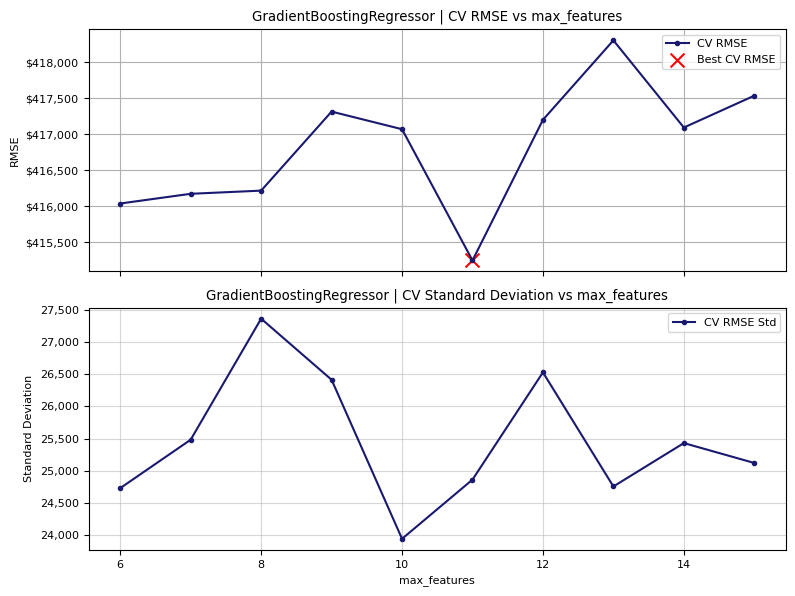

Executed successfully at: 2025-04-13 16:58:31
Results: {'n_estimators': 550, 'learning_rate': 0.14999999999999997, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0, 'max_features': 11, 'Test_Param': 'max_features', 'Model': 'GradientBoostingRegressor', '(R)MSE_found': 415248.987, 'cv_repeats': 5, 'execution_time': '00:26:42', 'timestamp': '2025-04-13 16:58:31'}


{'n_estimators': 550,
 'learning_rate': 0.14999999999999997,
 'max_depth': 4,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 1.0,
 'max_features': 11,
 'Test_Param': 'max_features',
 'Model': 'GradientBoostingRegressor',
 '(R)MSE_found': 415248.987,
 'cv_repeats': 5,
 'execution_time': '00:26:42',
 'timestamp': '2025-04-13 16:58:31'}

In [182]:
best_params_gb_max_features = sweep_parameter(
    model           = GradientBoostingRegressor,
    Parameters      = params_gb_dict,
    param           = 'max_features',
    parameter_list  = list(np.arange(6, X_train_best_gb_df.shape[1]+1, 1)),
    X_train         = X_train_best_gb_df,
    y_train         = y_2_train,
    X_test          = X_test_best_gb_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)
best_params_gb_max_features

In [190]:
params_gb_dict['max_features'] = best_params_gb_max_features['max_features']

In [201]:
# pass the best parameters to the model
results_dict_4_best_params_gb = run_model(
    GradientBoostingRegressor,
    feature_set = 'best_subset_gradient_boosting',
    X_train     = X_train_best_gb_df,
    y_train     = y_2_train,
    X_test      = X_test_best_gb_df,
    y_test      = y_2_test,
    show_RMSE   = True,
    n_jobs      = -1,
    **params_gb_dict
)
for key,val in results_dict_4_best_params_gb.items():
    print(f"{key}: {val}")

Inside run_model, cv_folds = 5
Running GradientBoostingRegressor with RMSE, feature set: best_subset_gradient_boosting


python(82652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82660) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82662) Malloc

Model: GradientBoostingRegressor | Feature Set: best_subset_gradient_boosting | CV RMSE = 418863.483 | STDVN = 27101.003
-----------------------------------------------------------------------------------------------
model: GradientBoostingRegressor
Feature_Set: best_subset_gradient_boosting
metric_label: RMSE
Num_Features: 15
mean_cv_mse: 418863.483
std_cv_mse: 27101.003
cv_folds: 5
n_repeats: 5
log_target: False
execution_time: 00:02:30
timestamp: 2025-04-13 22:49:11


In [199]:

param_dist = {
    'learning_rate':    np.arange(0.1,.11,0.01),
    'n_estimators':     list(np.arange(100, 1001, 50)),  #list(np.arange(380, 421, 5))               
    'max_depth' :       list(np.arange(2, 6, 1)),   #Pro Tip: Avoid setting this too high, or to None, as it can lead to overfitting and increased computation time.
    'max_features':     list(np.arange(8, 20)),  
    # 'bootstrap'   :    [True, False],  # Use bootstrap samples when building estimators 
}

best_params_gb_randomizedsearch_df = run_GridSearch_RandomizedSearch_CV(
    ensemble_model      = GradientBoostingRegressor,
    parameter_grid      = param_dist,
    X_train             = X_train_best_gb_df,
    y_train             = y_2_train,
    randomized_search   = True,
    verbose             = True,
    show_RMSE           = True,
    iterations          = 10,
    n_jobs              = -1,
    n_repeats           = 5,
    cv_folds            = 5,
    random_state        = random_state
)   
best_params_gb_randomizedsearch_df

Using RandomizedSearchCV............................................


python(81730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81740) Malloc

KeyboardInterrupt: 

In [191]:
param_dist = {
    'learning_rate':    np.arange(0.1,.11,0.01),
    'n_estimators':     list(np.arange(100, 1001, 50)),  #list(np.arange(380, 421, 5))               
    'max_depth' :       list(np.arange(2, 6, 1)),   #Pro Tip: Avoid setting this too high, or to None, as it can lead to overfitting and increased computation time.
    'max_features':     list(np.arange(8, 20)),  
    # 'bootstrap'   :    [True, False],  # Use bootstrap samples when building estimators 
}


# best_params_gridsearch_4_df = run_GridSearch_RandomizedSearch_CV(
#                                 ensemble_model      = GradientBoostingRegressor, 
#                                 parameter_grid      = param_dist, 
#                                 randomized_search   = False,
#                                 show_RMSE           = True,
#                                 X_train             = X_train,
#                                 y_train             = y_train,
#                                 iterations          = 5,
#                                 n_jobs              = -1,
#                                 verbose             = True,
#                                 n_repeats           = 5,
#                                 cv_folds            = 5,
#                                 random_state        = 42

# )

# best_params_gridsearch_4_df    

### 4. Random Forest Regression

In [192]:
params_rf_dict = random_forests_default_params.copy()
# params_rf_dict['max_features'] = None
params_rf_dict

X_train_best_rf_df = X_2_train_scaled_df[best_subset_random_forest]
X_test_best_rf_df  = X_2_test_scaled_df[best_subset_random_forest]

In [193]:
## Baseline Results
best_params_rf_baseline = results_dict_3_subset_rf

In [194]:
## n_estimators sweep

best_params_rf_nestimators = sweep_parameter(
    model           = RandomForestRegressor,
    Parameters      = params_rf_dict,
    param           = 'n_estimators',
    parameter_list  = list(np.arange(100, 1001, 100)),
    X_train         = X_train_best_rf_df,
    y_train         = y_2_train,
    X_test          = X_test_best_rf_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_rf_dict['n_estimators'] = best_params_rf_nestimators['n_estimators']
best_params_rf_nestimators

Running RandomForestRegressor with parameter sweep...




Sweeping n_estimators:   0%|          | 0/10 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 961996.33it/s]

Sweeping n_estimators:  10%|█         | 1/10 [01:32<13:51, 92.36s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 425303.877 | STDVN = 28154.361
-----------------------------------------------------------------------------------------------
n_estimators = 100: CV RMSE = 425,303.877
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 708497.30it/s]

Sweeping n_estimators:  20%|██        | 2/10 [04:44<20:08, 151.01s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 424488.419 | STDVN = 27738.176
-----------------------------------------------------------------------------------------------
n_estimators = 200: CV RMSE = 424,488.419
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 713317.01it/s]

Sweeping n_estimators:  30%|███       | 3/10 [09:31<24:53, 213.30s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 424190.444 | STDVN = 27366.621
-----------------------------------------------------------------------------------------------
n_estimators = 300: CV RMSE = 424,190.444
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 832203.17it/s]

Sweeping n_estimators:  40%|████      | 4/10 [15:34<27:12, 272.16s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 423944.221 | STDVN = 27404.357
-----------------------------------------------------------------------------------------------
n_estimators = 400: CV RMSE = 423,944.221
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 759837.68it/s]

Sweeping n_estimators:  50%|█████     | 5/10 [41:53<1:01:56, 743.36s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 423734.234 | STDVN = 27060.659
-----------------------------------------------------------------------------------------------
n_estimators = 500: CV RMSE = 423,734.234
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


python(36183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 896218.80it/s]

Sweeping n_estimators:  60%|██████    | 6/10 [1:00:09<57:33, 863.39s/it]

Model: RandomForestRegressor | Feature Set: None | CV RMSE = 423597.012 | STDVN = 27046.764
-----------------------------------------------------------------------------------------------
n_estimators = 600: CV RMSE = 423,597.012
Inside run_model, cv_folds = 5
Running RandomForestRegressor with RMSE, feature set: None


python(36742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.

Sweeping n_estimators:  60%|██████    | 6/10 [1:26:57<57:58, 869.61s/it]


KeyboardInterrupt: 

In [ ]:
## max_features sweep

best_params_rf_max_features = sweep_parameter(
    model           = RandomForestRegressor,
    Parameters      = params_rf_dict,
    param           = 'max_features',
    parameter_list  = list(np.arange(6, X_train_best_rf_df.shape[1]+1, 1)),
    X_train         = X_train_best_rf_df,
    y_train         = y_2_train,
    X_test          = X_test_best_rf_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_rf_dict['max_features'] = best_params_rf_max_features['max_features']
best_params_rf_max_features


In [ ]:
## max_depth sweep

best_params_rf_max_depth = sweep_parameter(
    model           = RandomForestRegressor,
    Parameters      = params_rf_dict,
    param           = 'max_depth',
    parameter_list  = list(np.arange(3, 8, 1)),
    X_train         = X_train_best_rf_df,
    y_train         = y_2_train,
    X_test          = X_test_best_rf_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_rf_dict['max_depth'] = best_params_rf_max_features['max_depth']
best_params_rf_max_depth

### 4. Bagging Regression

In [195]:
params_bagging_dict = bagging_params_default.copy()
# params_rf_dict['max_features'] = None
params_bagging_dict
print("Default BaggingRegressor parameters: ", params_bagging_dict)
X_train_best_bagging_df = X_2_train_scaled_df[best_subset_bagging]
X_test_best_bagging_df  = X_2_test_scaled_df[best_subset_bagging]


Default BaggingRegressor parameters:  {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42}


In [196]:
## Baseline Results
best_params_bagging_baseline = results_dict_3_subset_bagging_2

In [197]:
## n_estimators sweep

best_params_bagging_nestimators = sweep_parameter(
    model           = BaggingRegressor,
    Parameters      = params_bagging_dict,
    param           = 'n_estimators',
    parameter_list  = list(np.arange(100, 1001, 100)),
    X_train         = X_train_best_bagging_df,
    y_train         = y_2_train,
    X_test          = X_test_best_bagging_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_bagging_dict['n_estimators'] = best_params_bagging_nestimators['n_estimators']
best_params_bagging_nestimators

Running BaggingRegressor with parameter sweep...




Sweeping n_estimators:   0%|          | 0/10 [00:00<?, ?it/s]

Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: None


python(80368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80373) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80378) Malloc

Model: BaggingRegressor | Feature Set: None | CV RMSE = 420153.426 | STDVN = 26925.785
-----------------------------------------------------------------------------------------------
n_estimators = 100: CV RMSE = 420,153.426
Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: None


python(80479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 694421.19it/s]

Sweeping n_estimators:  20%|██        | 2/10 [06:34<27:54, 209.32s/it]

Model: BaggingRegressor | Feature Set: None | CV RMSE = 419170.762 | STDVN = 26756.05
-----------------------------------------------------------------------------------------------
n_estimators = 200: CV RMSE = 419,170.762
Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: None


python(80537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 806596.92it/s]

Sweeping n_estimators:  30%|███       | 3/10 [13:02<33:54, 290.58s/it]

Model: BaggingRegressor | Feature Set: None | CV RMSE = 418959.539 | STDVN = 26448.719
-----------------------------------------------------------------------------------------------
n_estimators = 300: CV RMSE = 418,959.539
Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: None


python(80844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Cross-Validation Progress: 100%|██████████| 25/25 [00:00<00:00, 540503.09it/s]

Sweeping n_estimators:  40%|████      | 4/10 [21:40<38:03, 380.66s/it]

Model: BaggingRegressor | Feature Set: None | CV RMSE = 418703.067 | STDVN = 26473.197
-----------------------------------------------------------------------------------------------
n_estimators = 400: CV RMSE = 418,703.067
Inside run_model, cv_folds = 5
Running BaggingRegressor with RMSE, feature set: None


python(81118) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81119) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.

Sweeping n_estimators:  40%|████      | 4/10 [32:36<48:54, 489.14s/it]


KeyboardInterrupt: 

In [ ]:
### max_samples sweep 

best_params_bagging_max_samples = sweep_parameter(
    model           = BaggingRegressor,
    Parameters      = params_bagging_dict,
    param           = 'max_samples',
    parameter_list  = 1.0,
    X_train         = X_train_best_bagging_df,
    y_train         = y_2_train,
    X_test          = X_test_best_bagging_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_bagging_dict['max_sanples'] = best_params_bagging_max_samples['max_samples']
best_params_bagging_max_samples

In [ ]:
## max_features sweep

best_params_bagging_max_features = sweep_parameter(
    model           = BaggingRegressor,
    Parameters      = params_bagging_dict,
    param           = 'max_features',
    parameter_list  = list(np.arange(6, X_train_best_bagging_df.shape[1]+1, 1)),
    X_train         = X_train_best_bagging_df,
    y_train         = y_2_train,
    X_test          = X_test_best_bagging_df,
    y_test          = y_2_test,
    verbose         = True,
    show_rmse       = True,
    n_iter_no_change= None,
    delta           = 0.001,
    n_jobs          = -1,
    n_repeats       = 5
)

params_bagging_dict['max_features'] = best_params_bagging_max_features['max_features']
best_params_bagging_max_features

### <font color='gold'>Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your **tuning strategy** for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a **ranking** of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

<font color='magenta'>

#### TUNING STRATEGY
The tuning strategy echoed our approach from previous assignments. For each model, limit the set of hyperparameters to a set of the most 'important' and then tune in order of importance. 

- For gradient boosting: {`learning_rate`, `n_estimators`, `max_depth`, `max_features`}
- For Random Forest Regressor: {`n_estimators`, `max_features`, `max_depth`}. We didn't tune for the `bootstrap` parameter and instead opted for the default = True. 
- BaggingRegressor :  {`n_estimators`, `max_samples`, `max_features`}. We didn't tune for the `bootstrap` parameter and instead opted for the default = True. 

Frankly, our broader strategy was: pray that the the task even finishes, and if it does, hope that maybe the results are interpretable. 

Parameter sweeps for both the Random Forest and Bagging Regressor proved maddeningly frustrating to complete. We have included our code in the cells above -- 


##### America's Next Top Model...
is Gradient Boosting Regressor, the winner by default because our parameter sweeps for BaggingRegressor and RandomForests are exhuasting our system resources before the tasks have a chance to complete. Gradient Boosting Regression on our best feature subset after fine-tuning our hyperparameters yielded the following result:

<font color='gold'>
- model: GradientBoostingRegressor
- Feature_Set: best_subset_gradient_boosting
- metric_label: RMSE
- Num_Features: 15
- mean_cv_mse: $418,863.483
- std_cv_mse: $27,101.003
</font>

#### Last Thoughts
The prospect of repeating steps 2 - 4 is anything but encouraging. There's simply too much expenditure for the slimmest of improvements; even then, there's so little of interpretative value. 

Our relatively fruitless efforts demonstrate an inescapable truth about modeling pretty much anything: garbage in, garbage out. No algorithms in the